In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print('Код запущен не в Google Colab!')

Mounted at /content/drive


# Вспомогательные функции

In [ ]:
# Импорт библиотек
# import requests
# from urllib.parse import urlencode
# import re
import os
# from urllib.parse import unquote
import cv2
import time
# import datetime
import numpy as np
from google.colab.patches import cv2_imshow
# import zipfile
import random
import json

In [ ]:
# Контекстный менеджер для измерения времени операций
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        # Расчет времени выполнения
        result_time = time.time()-self.t
        hour = int(result_time//3600)
        min = int(result_time//60)-hour*60
        sec = int(round(result_time%60))
        msec = round(1000*result_time%60)

        if hour > 0:
            print('\nВремя обработки: ' + str(hour)+' час. ' + str(min)+' мин.')
        elif min > 0:
            print('\nВремя обработки: ' + str(min)+' мин. ' + str(sec)+' сек.')
        elif sec > 0:
            print('\nВремя обработки: ' + str(sec)+' сек.')
        else:
            print('\nВремя обработки: ' + str(msec)+' мс.')

# Создание тестовой текстуры и JSON

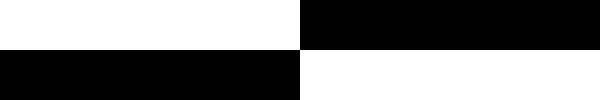

True

In [ ]:
text_texture = np.zeros((100, 600, 3), dtype="uint8")
cv2.rectangle(text_texture, (0, 0), (299, 49), (255, 255, 255), -1)
cv2.rectangle(text_texture, (300, 50), (599, 99), (255, 255, 255), -1)
cv2_imshow(text_texture)
cv2.imwrite('Test_Texture.jpg', text_texture)

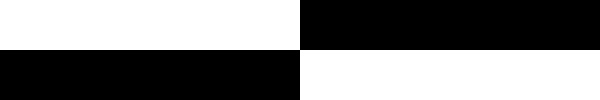

In [ ]:
# Создадим словарь для тестовой текстуры
folder = '/content/'
texture_filename = 'Test_Texture.jpg'
texture_path = (os.path.join(folder, texture_filename))

cv2_imshow(cv2.imread(texture_path))

texture_parameters = {      'name': 'Test Texture',
                      'real_width': 120,
                        'multiple': None,
                          'rotate': False,
                           'shift': 30}

# Сохраним словать в json
name, _ = os.path.splitext(texture_filename)
with open(os.path.join(folder, name +'.json'), 'w') as f:
    json.dump(texture_parameters, f)

# Функция создания полотна поля
Для корректного наложения текстуры, нам необходимо подать площадь которую необходимо замостить и параметры текстуры из json файла. Повороты текстуры будем осуществлять непосредственно во время преобразования.

In [ ]:
# Функция создания полотна поля
def create_texture_canvas(width, height, json_path, custom_shift = None, herringbone = None, rescale = None):
    '''
    Функция заполняет полотно текстурой на основании ее параметров указанных в JSON файле.
      width - желаемая ширина полотна (см);
      height - желаемая высота полотна (см);
      json_path - путь к JSON файлу с параметрами текстуры;
      custom_shift - смещение в направлении длины отличное от параметров текстуры по умолчанию (%);
      herringbone - укладка ёлочкой:
                        None или 0 - нет укладки ёлочкой;
                        1 и выше - ёлочка с соответствующим количеством планок;
                        Смещение при укладке ёлочкой не работает;
      recsale - коэффициент масштабирования фрагментов текстуры для экономии памяти.
    '''

    def random_fragment():
        # Создаем фрагмент
        fragment = random.choice(all_fragments_images)
        rotate = random.choice(rotate_codes)
        # При необходимости переворачиваем
        if rotate:
            fragment = cv2.rotate(fragment, rotate)
        return fragment

    # Загружаем данные из json
    with open(os.path.join(json_path), 'r') as f:
        data = json.load(f)

    # Извлекаем предполагаемое имя текстуры
    name, _ = os.path.splitext(json_path)

    # Создаем пути к файлам
    if data['multiple']:
        list_of_fragments = [name + '_' + ('00'+str(i))[-2:] for i in range(data['multiple'])]
    else:
        list_of_fragments = [name]

    # Определяем расширение файла текстуры
    for ext in ['.jpg','.png']:
        path = list_of_fragments[0] + ext
        if os.path.exists(path):
            extention = ext
            break

    # Если текстура не нашлась, выдаем ошибку
    if not extention:
        print(f'Текстура {list_of_fragments[0]} не найдена')
    # Выполняем основной цикл подготовки полотна
    else:
        # Загружаем все фрагменты
        all_fragments_images = []
        if not rescale:
            for fragment_path in list_of_fragments:
                all_fragments_images.append(cv2.imread(fragment_path + extention))
        else:
            texture_height, texture_width, _=  cv2.imread(list_of_fragments[0] + extention).shape
            for fragment_path in list_of_fragments:
                fragment = cv2.imread(fragment_path + extention)
                all_fragments_images.append(cv2.resize(fragment, (int(texture_width/rescale), int(texture_height/rescale))))

        # Определяем разрешение текстуры
        texture_height, texture_width, _ = all_fragments_images[0].shape

        # Вычисляем размеры текстуры в см
        real_width = data['real_width']
        real_height = data['real_width']*texture_height/texture_width

        # Вычисляем размер полотна в пикселах
        field_width = int(width*texture_width/real_width)
        field_height = int(height*texture_height/real_height)

        # Определяем необходимоть заполнения "елочкой"
        if herringbone:
            herringbone = herringbone
        else:
            try:
                herringbone = data['herringbone']
            except:
                herringbone = None

        # Определяем возможные повороты текстуры
        rotate_codes = [None]
        # Если повороты разрешен, то добавляем повороты на 180 градусов
        if data['rotate']:
            rotate_codes.append(1)
            # Если текстура квадратная, то добавляем 90 по и против часовой стрелки
            if texture_height == texture_width and not herringbone:
                rotate_codes.append(0)
                rotate_codes.append(1)

        # Определям цикл обработки в зависимости от потребности заполнения полотна "елочкой"
        if not herringbone:
            # Вычисляем минимальное количество текстур необходимое, чтобы замостить заданную площадь
            num_x = int(width//real_width) + 1
            num_y = int(height//real_height) + 1

            # Определяем смещение текстур
            if custom_shift:
                shift = custom_shift
            else:
                shift = data['shift']

            # Инициализируем счетчик смещения при необходимости
            if shift:
                shift_counter = 0
                num_x += 1

            # Проходимся циклом по текстурам и мостим площадь
            for y in range(num_y):
                for x in range(num_x):
                    # Создаем фрагмент
                    fragment = random_fragment()

                    # Собираем полоску фрагментов
                    if 'x_line' in locals():
                        x_line = np.hstack((x_line,fragment))
                    else:
                        x_line = fragment.copy()

                # При необходимости сдвигаем
                if shift:
                    dx = int(texture_width*shift_counter*shift/100%texture_width)
                    x_line = x_line[:,texture_width-dx:texture_width*num_x-dx,:]
                    shift_counter += 1

                # Собираем горизонтальные полоски в текстуру
                if 'y_line' in locals():
                    y_line = np.vstack((y_line, x_line))
                else:
                    y_line = x_line.copy()
                del x_line
            return y_line[:field_height,:field_width,:]

        # Если нужна "елочка"
        else:
            # Вычисление основных переменных
            f_w = field_width
            f_h = field_height
            t_l = texture_width
            t_w = texture_height

            t_w = t_w*herringbone

            if t_l < t_w:
                t_w, t_l = t_l, t_w
                t_rot = True
            else:
                t_rot = False

            # Создание шаблона главной диагонали
            main_diag = np.array([[h,h] for h in range(0,f_h+t_l,t_w)])

            # Корректировка длины главной диагонали
            to_max_x = (f_w-main_diag[-1][0])//t_w
            to_max_y = (f_h-main_diag[-1][1])//t_w

            # Добавление скорректированой главной диагонали в полотно точек
            grid = main_diag.copy()[:min(to_max_x,to_max_y)]

            # Цикл для копирования диагонали в направлении нижнего края
            for h in range(1,len(main_diag)):
                # Смещения диагонали по x и y
                d_x = h*(t_l-t_w)
                d_y = h*(t_l+t_w)
                # Вылел с левого края
                #to_zero = (d_x-t_l+t_w)//t_w
                delta = (d_x-t_l+t_w)//t_w*t_w
                # Расстояние от последней планки до края полотна (y координата последней планки минус ширина полотна c запасами)
                to_max_x = (f_w-(main_diag[-1][0]-d_x+delta))//t_w
                to_max_y = (f_h-(main_diag[-1][1]+d_y+delta))//t_w
                if to_max_x < 0 or to_max_y < 0:
                    grid = np.vstack((grid,(main_diag+[-d_x+delta,d_y+delta])[:min(to_max_x,to_max_y)]))
                else:
                    grid = np.vstack((grid,(main_diag+[-d_x+delta,d_y+delta])[:]))

            # Цикл для копирования диагонали в направлении правого края
            for h in range(1,len(main_diag)):
                # Смещения диагонали по x и y
                d_x = h*t_l
                d_y = h*t_l
                # Возвратное смещение диагонали для компенсации смещения вверх
                delta = (d_y-t_l)//t_w*t_w
                # Расстояние от последней планки до края полотна (y координата последней планки минус ширина полотна c запасами)
                to_max_x = (f_w-(main_diag[-1][0]+d_x+delta))//t_w
                to_max_y = (f_h-(main_diag[-1][1]-d_y+delta))//t_w

                # Корректировка количество точек диагонали, чтобы она не выходила за правый край
                if to_max_x < 0 or to_max_y < 0:
                    grid = np.vstack((grid,(main_diag+[d_x+delta,-d_y+delta])[:min(to_max_x,to_max_y)]))
                else:
                    grid = np.vstack((grid,main_diag+[d_x+delta,-d_y+delta]))

            image = np.zeros((f_h+2*t_l+2*t_w,f_w+2*t_l,3))
            grid = grid + [t_l,t_l+t_w]

            for point in grid.tolist():
                point = point
                xh_s = point[0]
                yh_s = point[1]
                xv_s = point[0]
                yv_s = point[1]+t_w
                xh_e = xh_s+t_l
                yh_e = yh_s+t_w
                xv_e = xv_s+t_w
                yv_e = yv_s+t_l

                if t_rot:
                    img_block_h = cv2.rotate(random_fragment(),0)
                    img_block_v = random_fragment()
                else:
                    img_block_h = random_fragment()
                    img_block_v = cv2.rotate(random_fragment(),0)

                for _ in range(herringbone-1):
                      if t_rot:
                          img_block_h = np.hstack((img_block_h, cv2.rotate(random_fragment(),0)))
                          img_block_v = np.vstack((img_block_v, random_fragment()))
                      else:
                          img_block_h = np.vstack((img_block_h, random_fragment()))
                          img_block_v = np.hstack((img_block_v, cv2.rotate(random_fragment(),0)))

                # Размещение сгенерированной текстуры на полотне
                image[yh_s:yh_e,xh_s:xh_e,:] = img_block_h
                image[yv_s:yv_e,xv_s:xv_e,:] = img_block_v

            return(image[t_l+t_w:-t_l-t_w,t_l:-t_l,:])

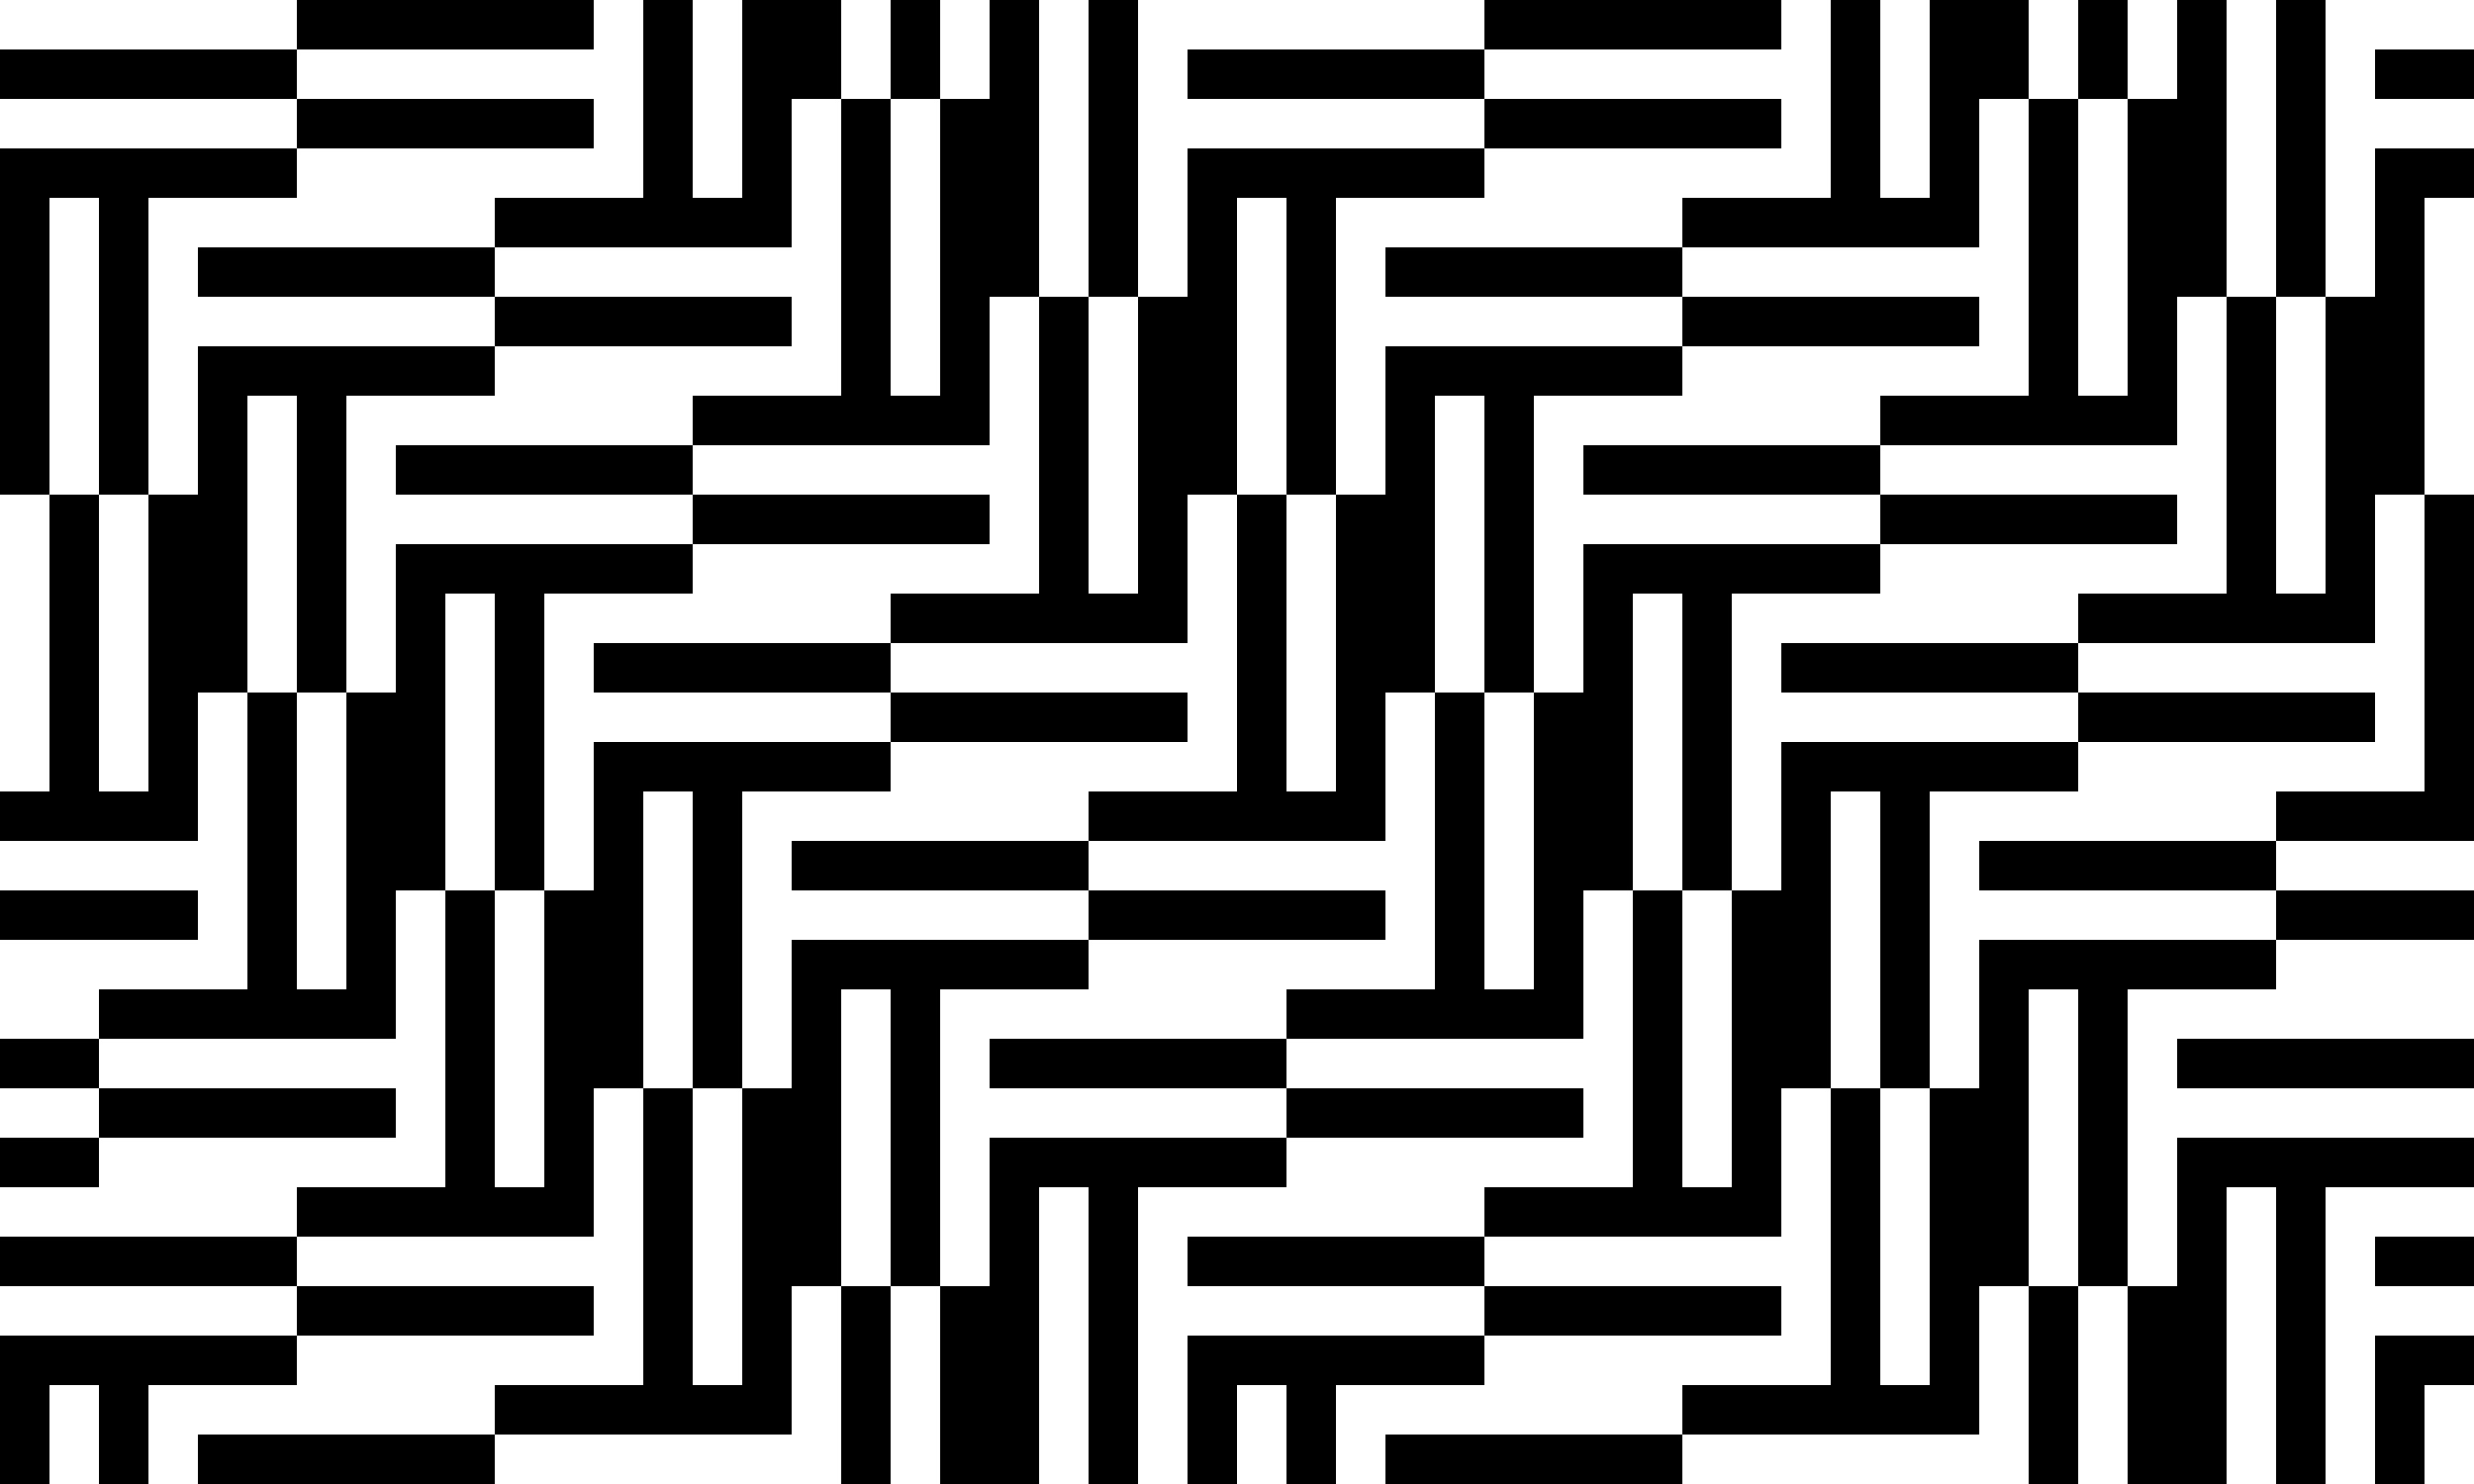

In [ ]:
# Проверка мощения полотна тестовой текстурой
texture_field = create_texture_canvas(500, 300, '/content/Test_Texture.json', custom_shift = None, herringbone = 2)
cv2_imshow(texture_field)

# Нанесение текстуры на маску по заданному цвету

In [ ]:
# Функция наложения текстуры по отдельному цвету маски
def texturing_by_mask_color(image, texture, mask, color):
    '''
    Функция заполняет изображение текстурой по цвету маски.
    Изображение, текстура и маска передаются NumPy массивом (cv2.imread)
    Цвет в виде кортежа или списка из трех каналов цветов (BGR если маска загружена cv2.imread)
    '''

    textured_image = image.copy()
    boolean_mask = ((mask[:,:,0] == color[0]) & (mask[:,:,1] == color[1]) & (mask[:,:,2] == color[2]))
    textured_image[boolean_mask] = texture[boolean_mask]
    return textured_image

# Построение маски по опорным точкам пола и потолка

In [ ]:
def build_mask(ceiling_points,
               floor_points,
               size = (800, 600),
               colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)],
               walls_color_delta = (0, 75, 0),
               x_edge = 10,
               y_edge = 10):
    '''
    Функция построения маски по опорным точкам потолка и пола. Дополняет маску до краев изображения.
    Стены строятся по последовательным  парам точек пола и потолка.
    Работает от 3-х точек и более. Если один из списков длиннее, то оставшиеся точки игнорируются.
    ceiling_points, floor_points - списки точек пола и потолка;
    size - размер изображения маски;
    colors - список цветов потолка, пола, стен для маски;
    walls_color_delta - смещение цветовой палитры для цвета стен.
    '''

    # Извлечение размеров
    width, height = size

    # Создание полигона потолка с добавлением углов изображения
    ceiling_mask = ceiling_points.copy()
    if ceiling_points[0][0] <= x_edge and ceiling_points[0][1] != 0:
        ceiling_mask = [[0,0]] + ceiling_mask
    if ceiling_points[-1][0] >= width - x_edge and ceiling_points[-1][1] != 0:
        ceiling_mask = ceiling_mask + [[width,0]]

    # Создание полигона пола с добавлением углов изображения
    floor_mask = floor_points.copy()
    if floor_points[0][0] <= x_edge and floor_points[0][1] != height:
        floor_mask = [[0,height]] + floor_mask
    if floor_points[-1][0] >= width - x_edge and floor_points[-1][1] != height:
        floor_mask = floor_mask + [[width,height]]

    # Создание полигонов стен с добавлением углов изображения
    wall_masks = []
    for i in range(0,min(len(ceiling_points),len(floor_points))-1):
        wall = [ceiling_points[i],floor_points[i],floor_points[i+1],ceiling_points[i+1]]
        wall_masks.append(wall)

    # Корекция точек маски левой стены
    if wall_masks[0][1][1] >= height - y_edge and wall_masks[0][1][0] != 0:
        wall_masks[0] = wall_masks[0][:1] + [[0,height]] + wall_masks[0][1:]
    if wall_masks[0][0][1] <= y_edge and wall_masks[0][0][0] != 0:
        wall_masks[0] = wall_masks[0][:1] + [[0,0]] + wall_masks[0][1:]

    # Корекция точек маски правой стены
    if wall_masks[-1][3][1] <= y_edge and wall_masks[-1][3][0] != width:
        wall_masks[-1] = wall_masks[-1][:3] + [[width,0]] + wall_masks[-1][3:]
    if wall_masks[-1][2][1] >= height - y_edge and wall_masks[-1][2][0] != width:
        wall_masks[-1] = wall_masks[-1][:3] + [[width,height]] + wall_masks[-1][3:]


    # Создание полотна для маски
    image_mask = np.zeros((height, width, 3), dtype="uint8")

    # Отображение маски потолка из полигона
    cv2.fillPoly(image_mask, pts=[np.array(ceiling_mask)], color=colors[0])
    # Отображение маски пола из полигона
    cv2.fillPoly(image_mask, pts=[np.array(floor_mask)], color=colors[1])
    # Отображение масок стен из полигонов
    for i in range(len(wall_masks)):
        wall_color = tuple(int(c) for c in (np.array(colors[2]) + np.array(walls_color_delta)*i)%256)
        cv2.fillPoly(image_mask, pts=[np.array(wall_masks[i])], color=wall_color)

    # Отображение точек потолка
    for i in range(len(ceiling_points)):
        cp_color = tuple(int(c) for c in (np.array((0,180,150)) + np.array((10,10,-70))*i)%256)
        cv2.circle(image_mask,ceiling_points[i],6,cp_color,-1)

    # Отображение точек пола
    for i in range(len(floor_points)):
        fl_color = tuple(int(c) for c in (np.array((0,0,255)) + np.array((70,70,-30))*i)%256)
        cv2.circle(image_mask,floor_points[i],6,fl_color,-1)

    return image_mask

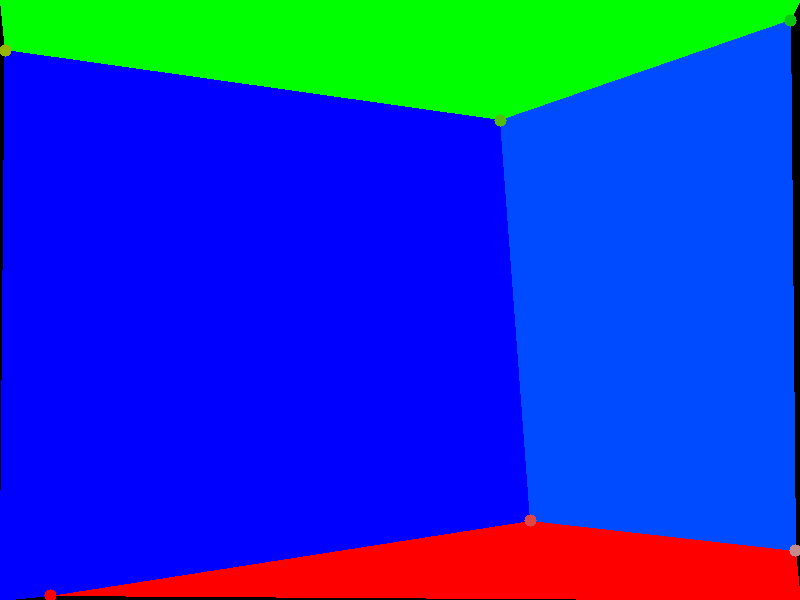

In [ ]:
# Тестирование функции создания маски
ceiling_points = [[5,50],[500,120],[790,20]]
floor_points = [[50,595],[530,520],[795,550]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

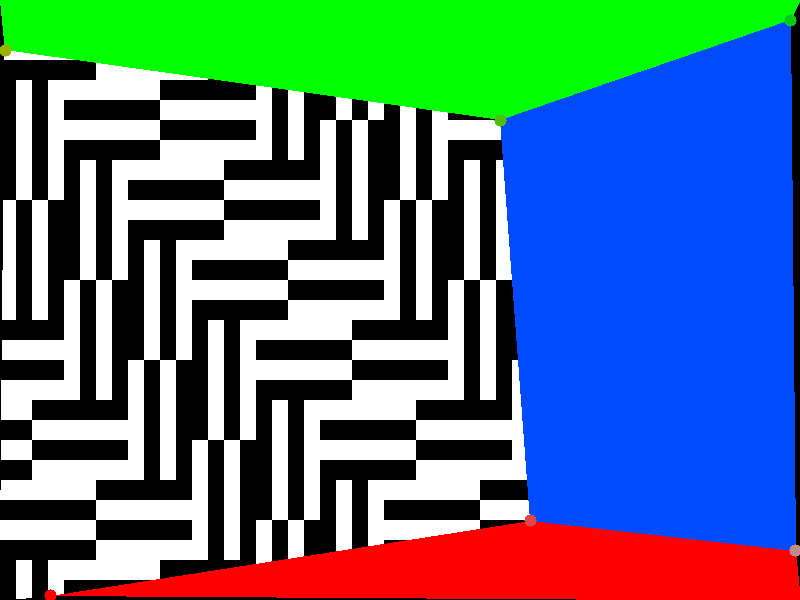

In [ ]:
# Тестирование текстурирования фрагмента маски
textured_mask = texturing_by_mask_color(mask, cv2.resize(texture_field, mask.shape[1::-1]), mask, (255,0,0))
cv2_imshow(textured_mask)

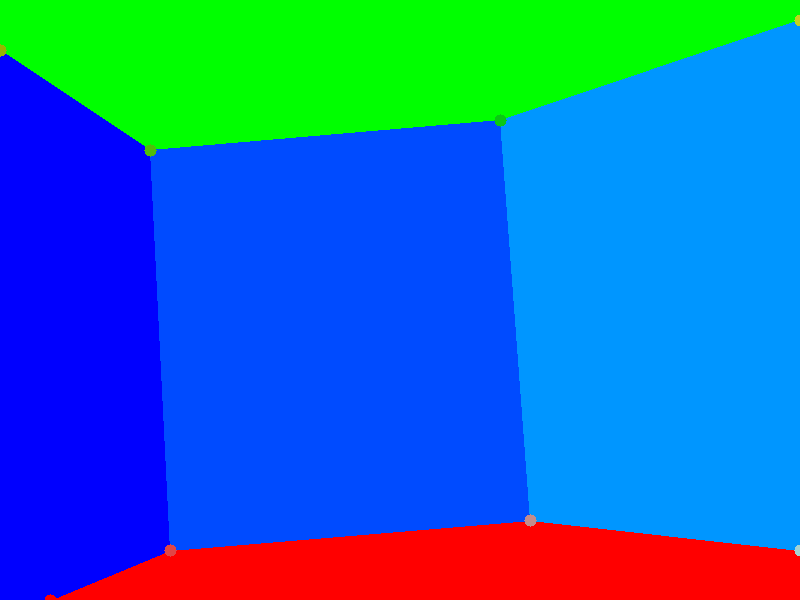

In [ ]:
# Тестирование функции создания маски
ceiling_points = [[0,50],[150,150],[500,120],[800,20]]
floor_points = [[50,600],[170,550],[530,520],[800,550]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

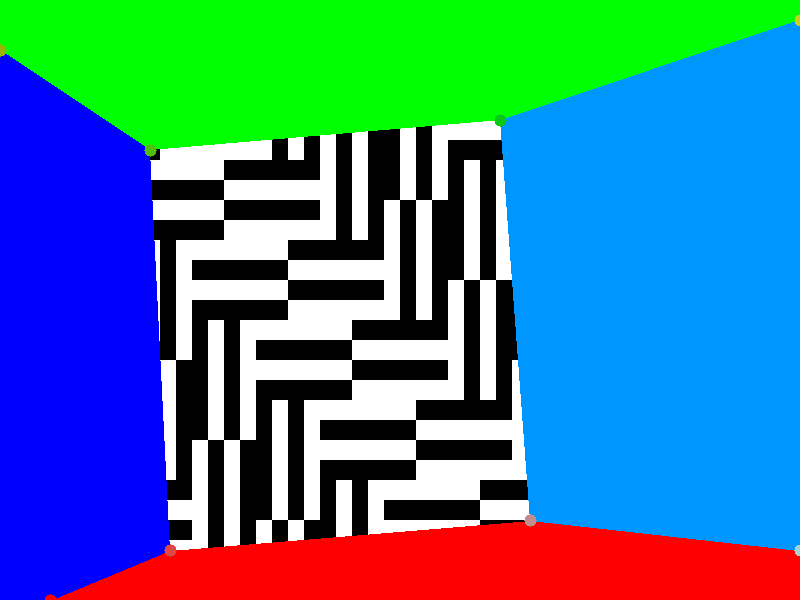

In [ ]:
# Тестирование текстурирования фрагмента маски
textured_mask = texturing_by_mask_color(mask, cv2.resize(texture_field, mask.shape[1::-1]), mask, (255,75,0))
cv2_imshow(textured_mask)

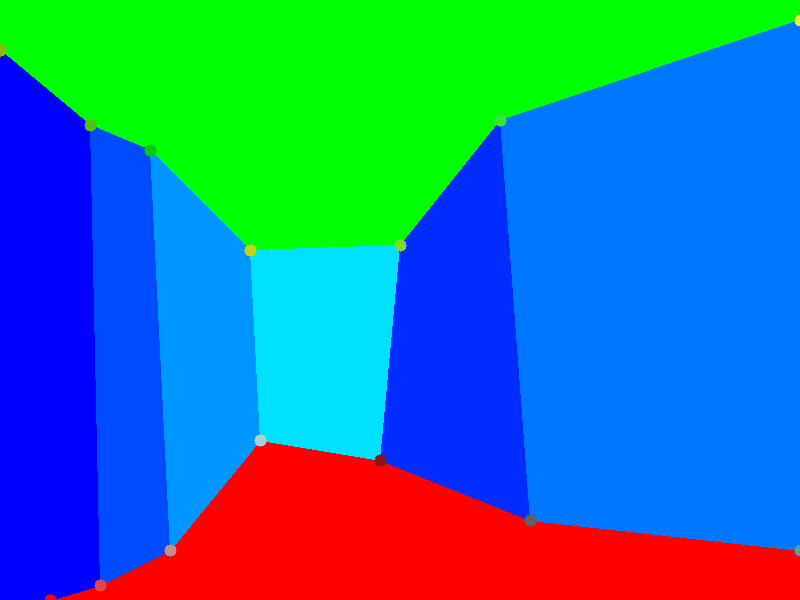

In [ ]:
# Тестирование функции создания маски
ceiling_points = [[0,50],[90,125],[150,150],[250,250],[400,245],[500,120],[800,20]]
floor_points = [[50,600],[100,585],[170,550],[260,440],[380,460],[530,520],[800,550]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

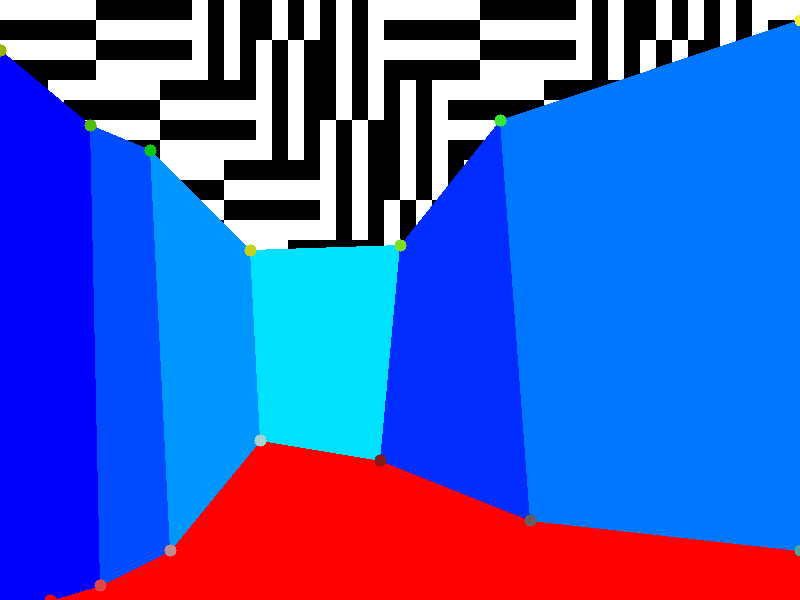

In [ ]:
# Тестирование текстурирования фрагмента маски
textured_mask = texturing_by_mask_color(mask, cv2.resize(texture_field, mask.shape[1::-1]), mask, (0,255,0))
cv2_imshow(textured_mask)

# Генерирование и сортировка точек пола и потолка

In [ ]:
# Генератор набора из n точек
def XY_gen(n, size = (800, 600)):
  X = np.random.randint(0,size[0],n)
  Y = np.random.randint(0,size[1],n)
  return [[X[i],Y[i]] for i in range(n)]

In [ ]:
def points_sorter(points):
  messages_list = ['Недостаточно точек. Добавьте точек!',
                   'Точек не четное количество. Добавьте или уберите точку!',
                   'Точек слишком много. Уберите лишние точки!',
                   'Точки успешно отсортированы!',
                   'Пол или потолок имеют обратную перспективу. Скорректируйте точки!']

  if (num_points := len(points)) < 6:
    return [], [], messages_list[0], []
  elif num_points%2 != 0:
    return [], [], messages_list[1], []
  elif num_points > 8:
    return [], [], messages_list[2], []
  else:
    # Сортируем список по y, а при равных y по х
    sorted_list = sorted(points, key=lambda k: [k[1], k[0]])
    # Делим список пополам и сортируем по x
    ceiling_points = sorted(sorted_list[:num_points//2], key=lambda k: [k[0], k[1]])
    floor_points = sorted(sorted_list[num_points//2:], key=lambda k: [k[0], k[1]])
    bad_points = []
    # Проверяем направление перспективы потолка
    if ceiling_points[0][1] > ceiling_points[1][1]:
      bad_points.append(ceiling_points[0])
      bad_points.append(ceiling_points[1])
    if ceiling_points[-1][1] > ceiling_points[-2][1]:
      bad_points.append(ceiling_points[-1])
      bad_points.append(ceiling_points[-2])
    # Проверем направление перспективы пола
    if floor_points[0][1] < floor_points[1][1]:
      bad_points.append(floor_points[0])
      bad_points.append(floor_points[1])
    if floor_points[-1][1] < floor_points[-2][1]:
      bad_points.append(floor_points[-1])
      bad_points.append(floor_points[-2])

    if len(bad_points) != 0:
      return ceiling_points, floor_points, messages_list[4], bad_points
    else:
      return ceiling_points, floor_points, messages_list[3], []

Пол или потолок имеют обратную перспективу. Скорректируйте точки!


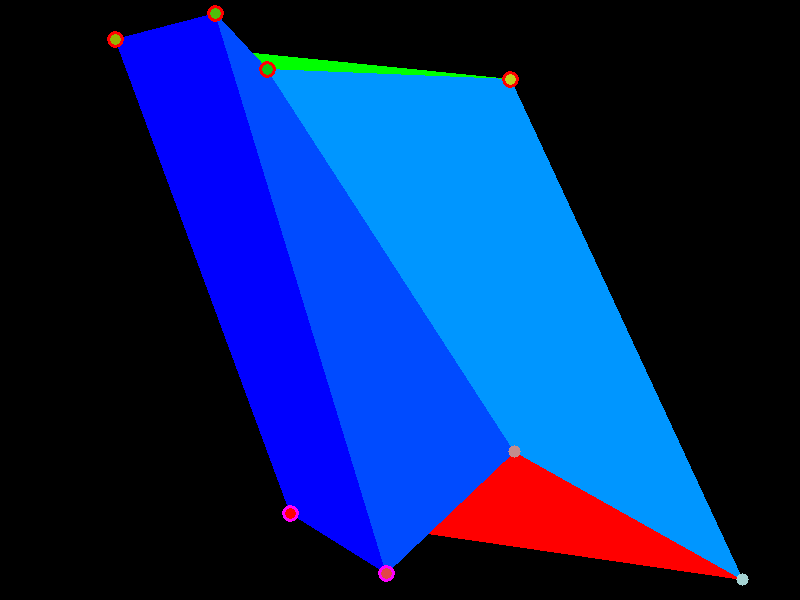

In [ ]:
points = XY_gen(8)
ceiling_points, floor_points,  message, bad_points = points_sorter(points)
print(message)

mask = build_mask(ceiling_points, floor_points)
# Отображение некорректных точек
for i in range(len(bad_points)):
    if bad_points[i] in ceiling_points:
      cv2.circle(mask,bad_points[i],7,(0,0,255),2)
    else:
      cv2.circle(mask,bad_points[i],7,(255,0,255),2)

cv2_imshow(mask)

# Преобразование текстуры по опорным точкам

In [ ]:
def texture_transformation(texture, source_points, destination_points, destination_size = (800, 600)):
    '''
    Функция преобразования текстуры по опорным точкам. Работает по 3-м или 4-м точкам. Больше игнорируется.
    texture - NumPy массив текстуры;
    source_points - список исходных точек на текстуре;
    destination_points - список конечных точек на изображении;
    destination_size - размер изображения на которое переносится текстура.
    '''
    # Проверяем длину переданных точек (заодно используем малоизвестный "моржовый оператор")
    if (len_points := min(len(source_points), len(destination_points))) > 3:
        hf, _ = cv2.findHomography(np.float32(source_points[:4]), np.float32(destination_points[:4]))
        warp_texture = cv2.warpPerspective(texture, hf, destination_size)
    elif len_points == 3:
        warp_matrix = cv2.getAffineTransform(np.float32(source_points[:3]), np.float32(destination_points[:3]))
        warp_texture = cv2.warpAffine(texture, warp_matrix, destination_size)
    else:
        warp_texture = np.zeros(destination_size + (3,), dtype="uint8")
    return warp_texture

In [ ]:
# Проверка преобразования текстуры
texture_field = create_texture_canvas(100, 60, '/content/Test_Texture.json', custom_shift = None, herringbone = 2)
print(texture_field.shape)

# Исходные точки как углы текстуры
source_points = [[0,0],[500,0],[0,300],[500,300]]
# Целевые точки как кривая трапеция
destination_points = [[100,100],[450,50],[25,275],[475,275]]

(300, 500, 3)


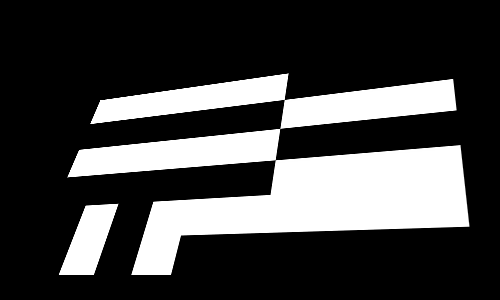

In [ ]:
# По 4-м точкам
cv2_imshow(texture_transformation(texture_field, source_points, destination_points, (500, 300)))

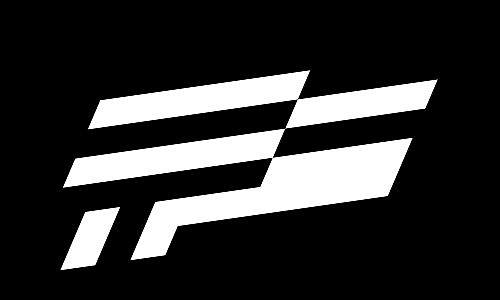

In [ ]:
# По 3-м точкам
cv2_imshow(texture_transformation(texture_field, source_points[:3], destination_points, (500, 300)))

# Развертка комнаты

In [ ]:
# Функции определения точек стен
def calc_walls(ceiling_points, floor_points):
    '''
    Функция постоения точек стен по последовательным парам точек пола и потолка.
    Работает от 3-х точек и более. Если один из списков длиннее, то оставшиеся точки игнорируются.
        ceiling_points, floor_points - списки точек пола и потолка.
    '''
    # Создание точек стен
    wall_points = []
    for i in range(0,min(len(ceiling_points), len(floor_points))-1):
        wall = [ceiling_points[i],floor_points[i],floor_points[i+1],ceiling_points[i+1]]
        wall_points.append(wall)
    return wall_points

In [ ]:
# Функция расчета дополнительных точек расширенной маски
def add_mask_points(ceiling_points,
                    floor_points,
                    wall_points,
                    size = (800, 600),
                    x_edge = 10,
                    y_edge = 10):
    '''
    Функция добавляет углы изображения к соответствующим опорным точкам.
    Необходима для корректного расчета размера текстуры для заливки.
    ceiling_points, floor_points, wall_points - списки точек пола и потолка;
    wall_points - размер изображения маски;
    '''

    # Извлечение размеров
    width, height = size

    # Создание полигона потолка с добавлением углов изображения
    ceiling_mask = ceiling_points.copy()
    if ceiling_points[0][0] <= x_edge and ceiling_points[0][1] != 0:
        ceiling_mask = [[0,0]] + ceiling_mask
    if ceiling_points[-1][0] >= width - x_edge and ceiling_points[-1][1] != 0:
        ceiling_mask = ceiling_mask + [[width,0]]

    # Создание полигона пола с добавлением углов изображения
    floor_mask = floor_points.copy()
    if floor_points[0][0] <= x_edge and floor_points[0][1] != height:
        floor_mask = [[0,height]] + floor_mask
    if floor_points[-1][0] >= width - x_edge and floor_points[-1][1] != height:
        floor_mask = floor_mask + [[width,height]]

    # Создание полигонов стен с добавлением углов изображения
    wall_masks = []
    for i in range(0,min(len(ceiling_points),len(floor_points))-1):
        wall = [ceiling_points[i],floor_points[i],floor_points[i+1],ceiling_points[i+1]]
        wall_masks.append(wall)

    # Корекция точек маски левой стены
    if wall_masks[0][1][1] >= height - y_edge and wall_masks[0][1][0] != 0:
        wall_masks[0] = wall_masks[0][:1] + [[0,height]] + wall_masks[0][1:]
    if wall_masks[0][0][1] <= y_edge and wall_masks[0][0][0] != 0:
        wall_masks[0] = wall_masks[0][:1] + [[0,0]] + wall_masks[0][1:]

    # Корекция точек маски правой стены
    if wall_masks[-1][3][1] <= y_edge and wall_masks[-1][3][0] != width:
        wall_masks[-1] = wall_masks[-1][:3] + [[width,0]] + wall_masks[-1][3:]
    if wall_masks[-1][2][1] >= height - y_edge and wall_masks[-1][2][0] != width:
        wall_masks[-1] = wall_masks[-1][:3] + [[width,height]] + wall_masks[-1][3:]

    return ceiling_mask, floor_mask, wall_masks

In [ ]:
# Функции расчета размеров развертки комнаты
def calc_room_skin_sizes(ceiling_points,
                         floor_points,
                         r_l, r_w, r_h):
    '''
    Функция вычисляет размеры развертки текстур комнаты на основании ее размеров.
      ceiling_points - опорные точки потолка;
      floor_points - опорные точки пола;
      r_l, r_w, r_h - длина, ширина и высота комнаты в см.
    '''

    # Функция для вычисления расстояния между точками через вектора NumPy
    def calc_dist(points):
        square = np.square(np.array(points[0]) - np.array(points[1]))
        sum_square = np.sum(square)
        return  np.sqrt(sum_square)

    # Создание точек стен
    wall_points = calc_walls(ceiling_points, floor_points)

    # Определяем самую длинную видимую сторону
    walls_skin_size = [top_left_w_edge := calc_dist([wall_points[0][0], wall_points[0][3]]),
                       bottom_left_w_edge := calc_dist([wall_points[0][1], wall_points[0][2]]),
                       top_rigth_w_edge := calc_dist([wall_points[-1][0], wall_points[-1][3]]),
                       bottom_rigth_w_edge := calc_dist([wall_points[-1][1], wall_points[-1][2]])]

    max_edge_index = walls_skin_size.index(max(walls_skin_size))
    walls_edges_scale = list(np.array(walls_skin_size)/walls_skin_size[max_edge_index])

   # Вычисление длин ребер потолка
    if (len_points := min(len(ceiling_points), len(floor_points))) == 3:
        ceiling_skin_size = [r_l*walls_edges_scale[0],r_w*walls_edges_scale[2]]
    elif len_points == 4:
        # Вычисляем какая из граней длиннее и в соответствии с этим корректируем вторую
        ceiling_skin_size = [r_l*walls_edges_scale[0], r_w, r_l*walls_edges_scale[2]]
    else:
        print('Меньше 2-х и больше 4-х точек пока не обрабатываем!')
        ceiling_skin_size = []

    # Вычисление длин ребер пола
    if (len_points := min(len(ceiling_points),len(floor_points))) == 3:
        floor_skin_size = [r_l*walls_edges_scale[1],r_w*walls_edges_scale[3]]
    elif len_points == 4:
        floor_skin_size = [r_l*walls_edges_scale[1], r_w, r_l*walls_edges_scale[3]]

    # Вычисление размеров стен
    walls_skin_size = []

    # Вычисление длин ребер левой стены
    walls_skin_size.append([r_l*walls_edges_scale[0], r_h, r_l*walls_edges_scale[1]])

    # Проверка количества стен
    if len_points == 4:
        # Добавляем среднюю сторону
        walls_skin_size.append([r_w, r_h, r_w])
        # Вычисление длин ребер правой стены
        walls_skin_size.append([r_l*walls_edges_scale[2], r_h, r_l*walls_edges_scale[3]])

    elif len_points == 3:
        # Вычисление длин ребер правой стены
        walls_skin_size.append([r_w*walls_edges_scale[2], r_h, r_w*walls_edges_scale[3]])

    return ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points

In [ ]:
# Функция расчета точек и отрисовки развертки комнаты
def draw_room_skin(ceiling_skin_size,
                   floor_skin_size,
                   walls_skin_size,
                   r_l, r_w, r_h,
                   colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)],
                   walls_color_delta = (0, 75, 0)):

    '''
    Функция преобразует размеры и отображает развертку.
      ceiling_skin_size - размеры потолка в см;
      floor_skin_size - размеры пола в см;
      walls_skin_size - размеры стен в см;
      r_l, r_w, r_h - длина, ширина и высота комнаты в см;
      colors - список цветов потолка, пола, стен для маски;
      walls_color_delta - смещение цветовой палитры для цвета стен.
    '''

    # Обработка ситуации с 2-мя видимыми стенами
    if (len_points := min(len(ceiling_skin_size), len(floor_skin_size), len(walls_skin_size))) == 2:
        skin_map = np.zeros((int(r_l*2+r_h),int(r_l+r_w),3), dtype="uint8")
        skin_ceiling_points = [[r_l,r_l-ceiling_skin_size[0]],[r_l,r_l],[r_l+ceiling_skin_size[1],r_l]]
        skin_floor_points = [[r_l,r_l+r_h+floor_skin_size[0]],[r_l,r_l+r_h],[r_l+floor_skin_size[1],r_l+r_h]]
        skin_walls_points = []
        skin_walls_points.append([[r_l-walls_skin_size[0][0],r_l],[r_l-walls_skin_size[0][2],r_l+walls_skin_size[0][1]],[r_l,r_l+walls_skin_size[0][1]],[r_l,r_l]])
        skin_walls_points.append([[r_l,r_l],[r_l,r_l+walls_skin_size[1][1]],[r_l+walls_skin_size[1][2],r_l+walls_skin_size[1][1]],[r_l+walls_skin_size[1][0],r_l]])
    # Обработка ситуации с 3-мя видимыми стенами
    elif len_points == 3:
        skin_map = np.zeros((int(r_l*2+r_h),int(r_l*2+r_w),3), dtype="uint8")
        skin_ceiling_points = [[r_l,r_l-ceiling_skin_size[0]],[r_l,r_l],[r_l+r_w,r_l],[r_l+r_w,r_l-ceiling_skin_size[2]]]
        skin_floor_points = [[r_l,r_l+r_h+floor_skin_size[0]],[r_l,r_l+r_h],[r_l+r_w,r_l+r_h],[r_l+r_w,r_l+r_h+floor_skin_size[2]],]
        skin_walls_points = []
        skin_walls_points.append([[r_l-walls_skin_size[0][0],r_l],[r_l-walls_skin_size[0][2],r_l+walls_skin_size[0][1]],[r_l,r_l+walls_skin_size[1][1]],[r_l,r_l]])
        skin_walls_points.append([[r_l,r_l],[r_l,r_l+r_h],[r_l+r_w,r_l+r_h],[r_l+r_w,r_l]])
        skin_walls_points.append([[r_l+r_w,r_l],[r_l+r_w,r_l+walls_skin_size[1][1]],[r_l+r_w+walls_skin_size[2][2],r_l+walls_skin_size[1][1]],[r_l+r_w+walls_skin_size[2][0],r_l]])
    else:
        print('Меньше 2-х и больше 4-х стен пока не обрабатываем!')

    if 'skin_map' in locals():
        # Отображение развертки потолка из полигона
        cv2.fillPoly(skin_map, pts=[np.array(skin_ceiling_points).astype(np.int64)], color=colors[0])
        # Отображение маски пола из полигона
        cv2.fillPoly(skin_map, pts=[np.array(skin_floor_points).astype(np.int64)], color=colors[1])
        # Отображение масок стен из полигонов
        for i in range(len(skin_walls_points)):
            wall_color = tuple(int(c) for c in (np.array(colors[2]) + np.array(walls_color_delta)*i)%256)
            cv2.fillPoly(skin_map, pts=[np.array(skin_walls_points[i]).astype(np.int64)], color=wall_color)

        cv2_imshow(skin_map)

In [ ]:
# Функция расчета точек
def calc_room_skin_points(ceiling_skin_size,
                          floor_skin_size,
                          walls_skin_size,
                          r_l, r_w, r_h):

    '''
    Функция преобразует размеры развертки в точки для наложения на текстуру.
      ceiling_skin_size - размеры потолка в см;
      floor_skin_size - размеры пола в см;
      walls_skin_size - размеры стен в см;
      r_l, r_w, r_h - длина, ширина и высота комнаты в см;
      colors - список цветов потолка, пола, стен для маски;
      walls_color_delta - смещение цветовой палитры для цвета стен.
    '''

    # Обработка ситуации с 2-мя видимыми стенами
    if (len_points := min(len(ceiling_skin_size), len(floor_skin_size), len(walls_skin_size))) == 2:
        skin_ceiling_points = [[r_l,r_l-ceiling_skin_size[0]],[r_l,r_l],[r_l+ceiling_skin_size[1],r_l]]
        skin_floor_points = [[r_l,r_l+r_h+floor_skin_size[0]],[r_l,r_l+r_h],[r_l+floor_skin_size[1],r_l+r_h]]
        skin_walls_points = []
        skin_walls_points.append([[r_l-walls_skin_size[0][0],r_l],[r_l-walls_skin_size[0][2],r_l+walls_skin_size[0][1]],[r_l,r_l+walls_skin_size[0][1]],[r_l,r_l]])
        skin_walls_points.append([[r_l,r_l],[r_l,r_l+walls_skin_size[1][1]],[r_l+walls_skin_size[1][2],r_l+walls_skin_size[1][1]],[r_l+walls_skin_size[1][0],r_l]])
    # Обработка ситуации с 3-мя видимыми стенами
    elif len_points == 3:
        skin_ceiling_points = [[r_l,r_l-ceiling_skin_size[0]],[r_l,r_l],[r_l+r_w,r_l],[r_l+r_w,r_l-ceiling_skin_size[2]]]
        skin_floor_points = [[r_l,r_l+r_h+floor_skin_size[0]],[r_l,r_l+r_h],[r_l+r_w,r_l+r_h],[r_l+r_w,r_l+r_h+floor_skin_size[2]],]
        skin_walls_points = []
        skin_walls_points.append([[r_l-walls_skin_size[0][0],r_l],[r_l-walls_skin_size[0][2],r_l+walls_skin_size[0][1]],[r_l,r_l+walls_skin_size[1][1]],[r_l,r_l]])
        skin_walls_points.append([[r_l,r_l],[r_l,r_l+r_h],[r_l+r_w,r_l+r_h],[r_l+r_w,r_l]])
        skin_walls_points.append([[r_l+r_w,r_l],[r_l+r_w,r_l+walls_skin_size[1][1]],[r_l+r_w+walls_skin_size[2][2],r_l+walls_skin_size[1][1]],[r_l+r_w+walls_skin_size[2][0],r_l]])
    else:
        print('Меньше 2-х и больше 4-х стен пока не обрабатываем!')
        return [], [], []

    return skin_ceiling_points, skin_floor_points, skin_walls_points

# Функция отрисовки развертки комнаты по точкам
def create_room_skin(skin_ceiling_points,
                     skin_floor_points,
                     skin_walls_points,
                     map_size,
                     delta_x = 0, delta_y = 0,
                     colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)],
                     colors_delta = [(0, 50, 0), (0, 0, 50), (0, 75, 0)]
                     ):

    '''
    Функция создает изображение развертки.
      skin_ceiling_points - точки развертки потолка в см/px;
      skin_floor_points - точки развертки пола в см/px;
      skin_walls_points - точки развертки стен в см/px;
      map_size - размер полотна для отображения развертки в см/px (надо бы считать автоматически, но это вспомогательная функция);
      colors - список цветов потолка, пола, стен для маски;
      walls_color_delta - смещение цветовой палитры для цвета стен.
    '''

    #skin_map = np.zeros(map_size+(3,), dtype="uint8")
    skin_map = np.zeros((map_size[1]+delta_y, map_size[0]+delta_x,3), dtype="uint8")
    print(skin_map.shape)

    # Отображение развертки потолка из полигона
    cv2.fillPoly(skin_map, pts=[np.array(skin_ceiling_points).astype(np.int64)+np.array([delta_x,delta_y])], color=colors[0])
    # Отображение маски пола из полигона
    cv2.fillPoly(skin_map, pts=[np.array(skin_floor_points).astype(np.int64)+np.array([delta_x,delta_y])], color=colors[1])
    # Отображение масок стен из полигонов
    for i in range(len(skin_walls_points)):
        wall_color = tuple(int(c) for c in (np.array(colors[2]) + np.array(colors_delta[2])*i)%256)
        cv2.fillPoly(skin_map, pts=[np.array(skin_walls_points[i]).astype(np.int64)+np.array([delta_x,delta_y])], color=wall_color)

    return skin_map

#Расчет угловых точек изображения для переноса на развертку

In [ ]:
def skin_recalculator(points, mask, skin_points):

    '''
    Функция переносит дополнительные точки маски на развертку, создавая дополненную развертку.
       points - список точек элемента маски;
       mask - дополненный список точек элементов маски;
       skin_points - точки развертки.
    '''

    if len(points) < len(mask):
        # Проверяем длину переданных точек (заодно используем малоизвестный "моржовый оператор")
        if (len_points := len(points)) > 3:
            h_matrix, _ = cv2.findHomography(np.float32(points[:4]), np.float32(skin_points[:4]))
            transformed_pts = np.int16(cv2.perspectiveTransform(np.float32(mask).reshape(-1, 1, 2), h_matrix).reshape(np.float32(mask).shape))
            return transformed_pts.tolist()
        elif len_points == 3:
            a_matrix = cv2.getAffineTransform(np.float32(points[:3]), np.float32(skin_points[:3]))
            transformed_pts = []
            for point in mask:
              #print(np.dot(a_matrix,[point[0],point[1],1]))
              transformed_pts.append(np.dot(a_matrix,[point[0],point[1],1]).tolist())
            return transformed_pts
    else:
        return skin_points

In [ ]:
def room_skin_corrector(ceiling_points, floor_points, wall_points,
                        ceiling_mask, floor_mask, wall_masks,
                        skin_ceiling_points, skin_floor_points, skin_walls_points):

    '''
    Функция единовременной обработки всех масок и разверток.
    '''

    re_skin_ceiling_points = skin_recalculator(ceiling_points, ceiling_mask, skin_ceiling_points)
    re_skin_floor_points = skin_recalculator(floor_points, floor_mask, skin_floor_points)
    re_skin_walls_points = []
    for i in range(len(wall_points)):
        re_skin_walls_points.append(skin_recalculator(wall_points[i], wall_masks[i], skin_walls_points[i]))

    return re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points

In [ ]:
# Функция отображения точек на тексуре
def draw_points(image, points, start_color, delta, radius):

    # Отображение точек потолка
    for i in range(len(points)):
        cp_color = tuple(int(c) for c in (np.array(start_color) + np.array(delta)*i)%256)
        cv2.circle(image,(int(points[i][0]),int(points[i][1])),radius,cp_color,-1)

    return image

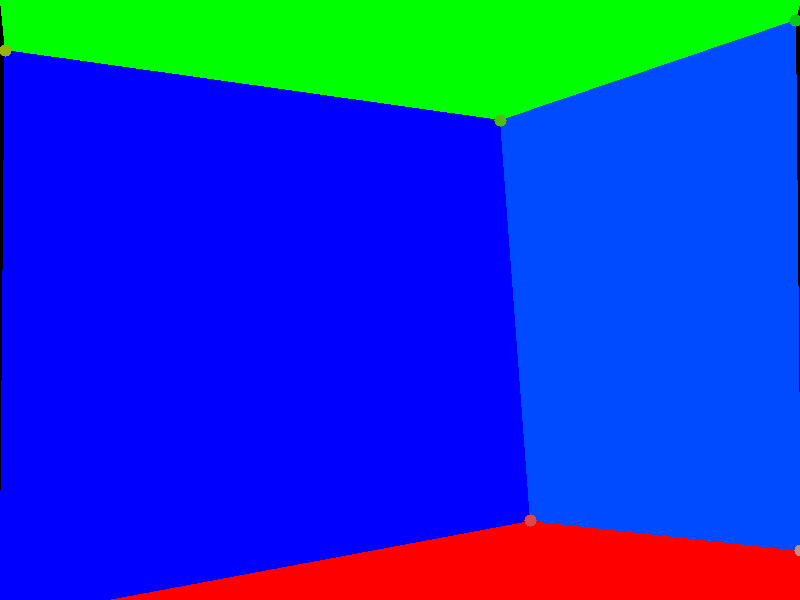

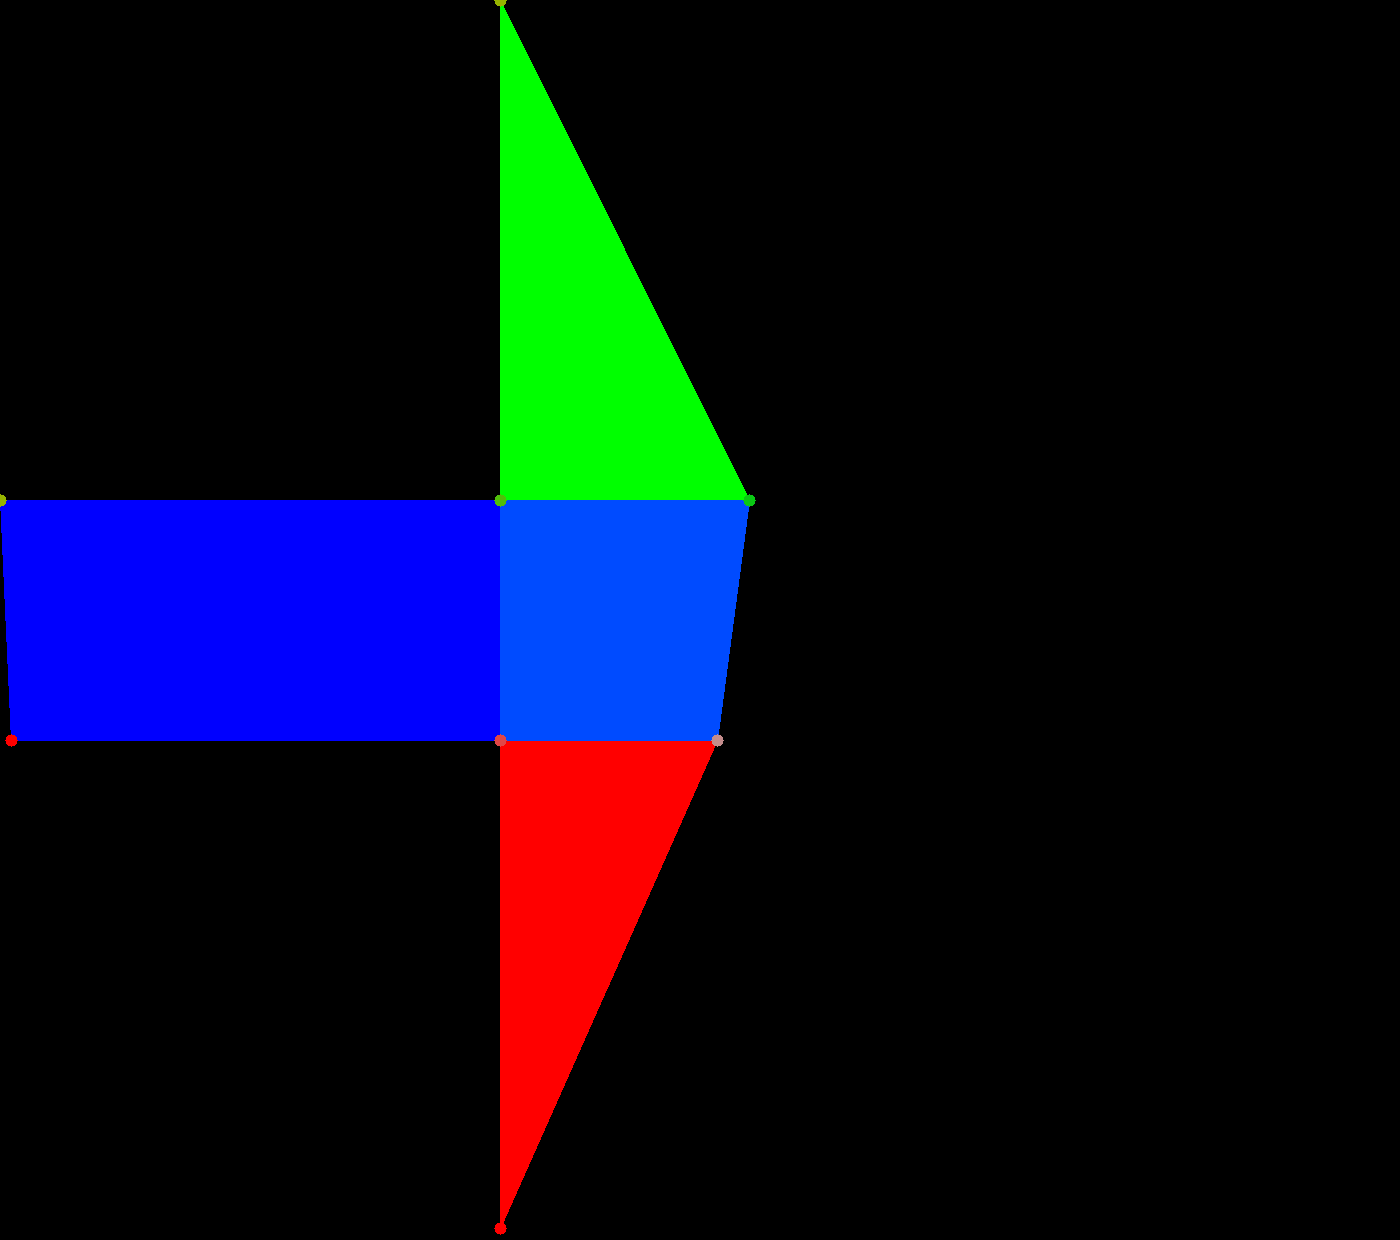

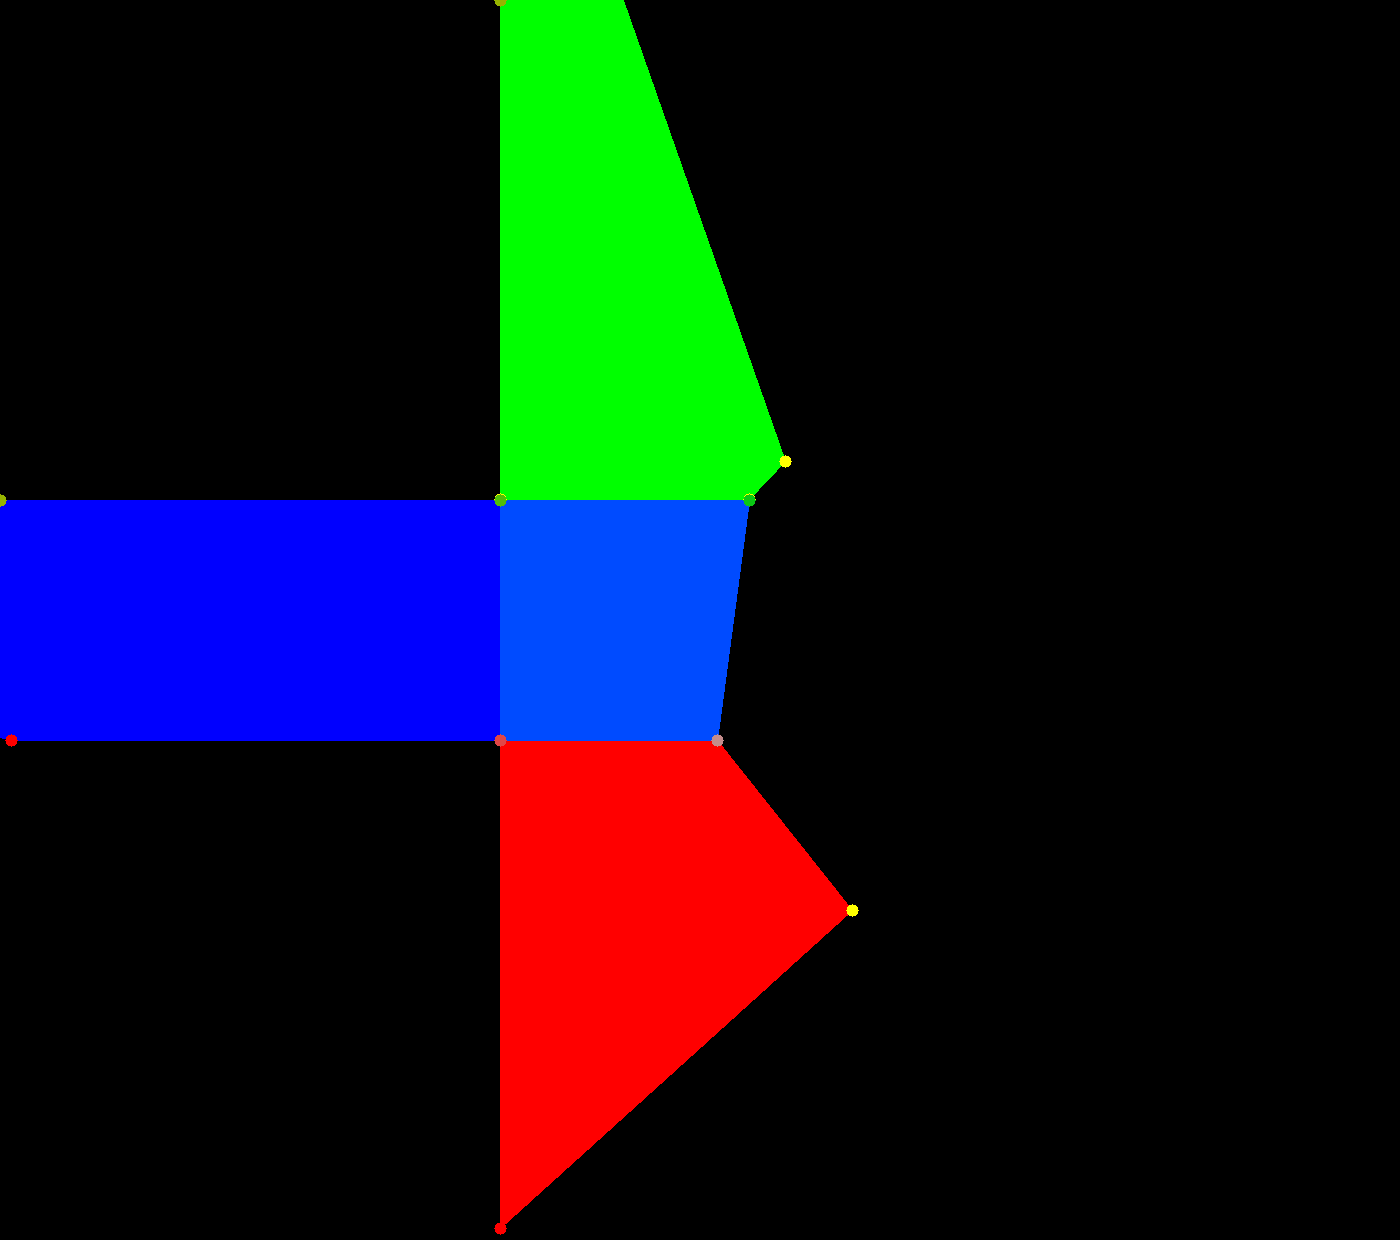

In [ ]:
# Тестирование функции создания маски и ее развертки
ceiling_points = [[5,50],[500,120],[795,20]]
floor_points = [[50,610],[530,520],[800,550]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, 500, 400, 240)

ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (800, 600))

skin_ceiling_points, skin_floor_points, skin_walls_points = calc_room_skin_points(ceiling_skin_size, floor_skin_size, walls_skin_size, 500, 400, 240)

room_skin = create_room_skin(skin_ceiling_points, skin_floor_points, skin_walls_points, (1240, 1400))

room_skin = draw_points(room_skin, skin_ceiling_points, (0,180,150), (10,10,-70), 6)
room_skin = draw_points(room_skin, skin_floor_points, (0,0,255), (70,70,-30), 6)

room_skin = draw_points(room_skin, [skin_walls_points[0][0]], (0,180,150), (10,10,-70), 6)
room_skin = draw_points(room_skin, [skin_walls_points[0][1]], (0,0,255), (70,70,-30), 6)

cv2_imshow(room_skin)

re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points = room_skin_corrector(ceiling_points, floor_points, wall_points, ceiling_mask, floor_mask, wall_masks, skin_ceiling_points, skin_floor_points, skin_walls_points)

room_re_skin = create_room_skin(re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points, (1240, 1400))

room_re_skin = draw_points(room_re_skin, re_skin_ceiling_points, (0,255,255), (0,0,0), 6)
room_re_skin = draw_points(room_re_skin, re_skin_floor_points, (0,255,255), (0,0,0), 6)
for re_wall_points in re_skin_walls_points:
  room_re_skin = draw_points(room_re_skin, re_wall_points, (0,255,255), (0,0,0), 6)

room_re_skin = draw_points(room_re_skin, skin_ceiling_points, (0,180,150), (10,10,-70), 6)
room_re_skin = draw_points(room_re_skin, skin_floor_points, (0,0,255), (70,70,-30), 6)

room_re_skin = draw_points(room_re_skin, [skin_walls_points[0][0]], (0,180,150), (10,10,-70), 6)
room_re_skin = draw_points(room_re_skin, [skin_walls_points[0][1]], (0,0,255), (70,70,-30), 6)

cv2_imshow(room_re_skin)

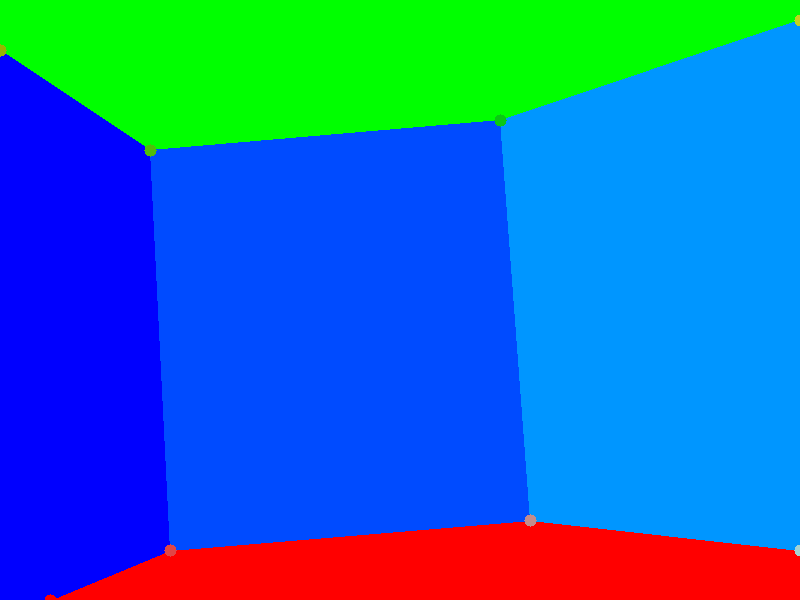

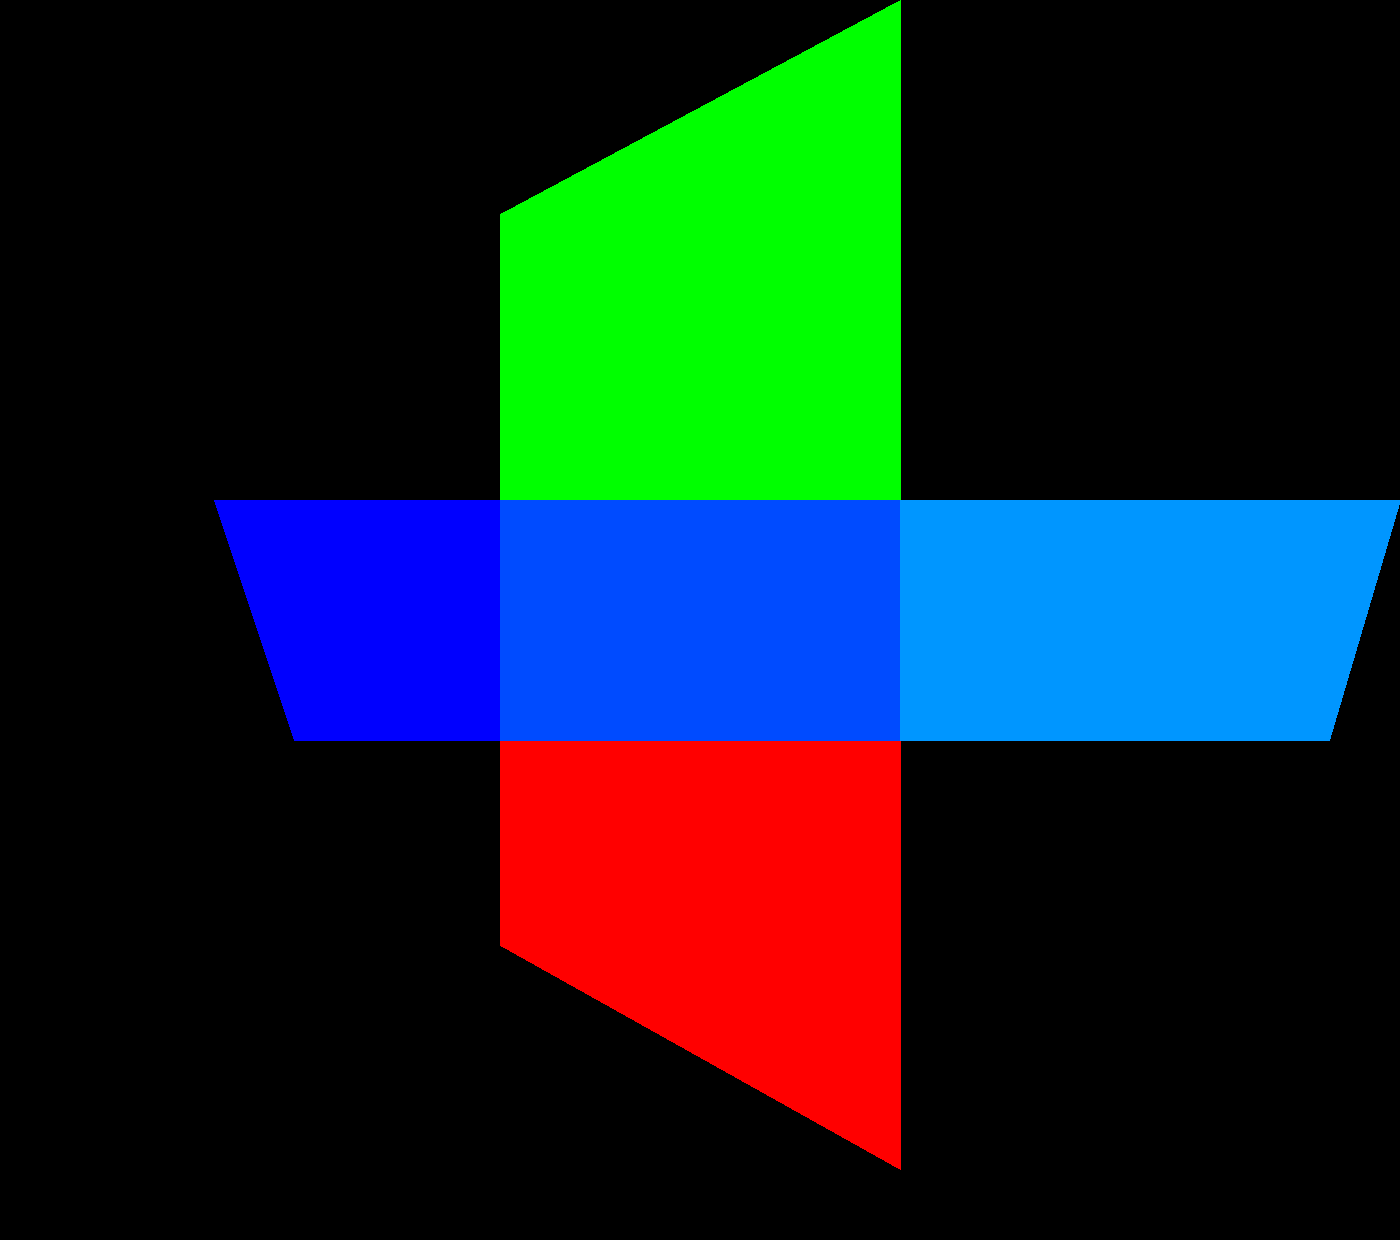

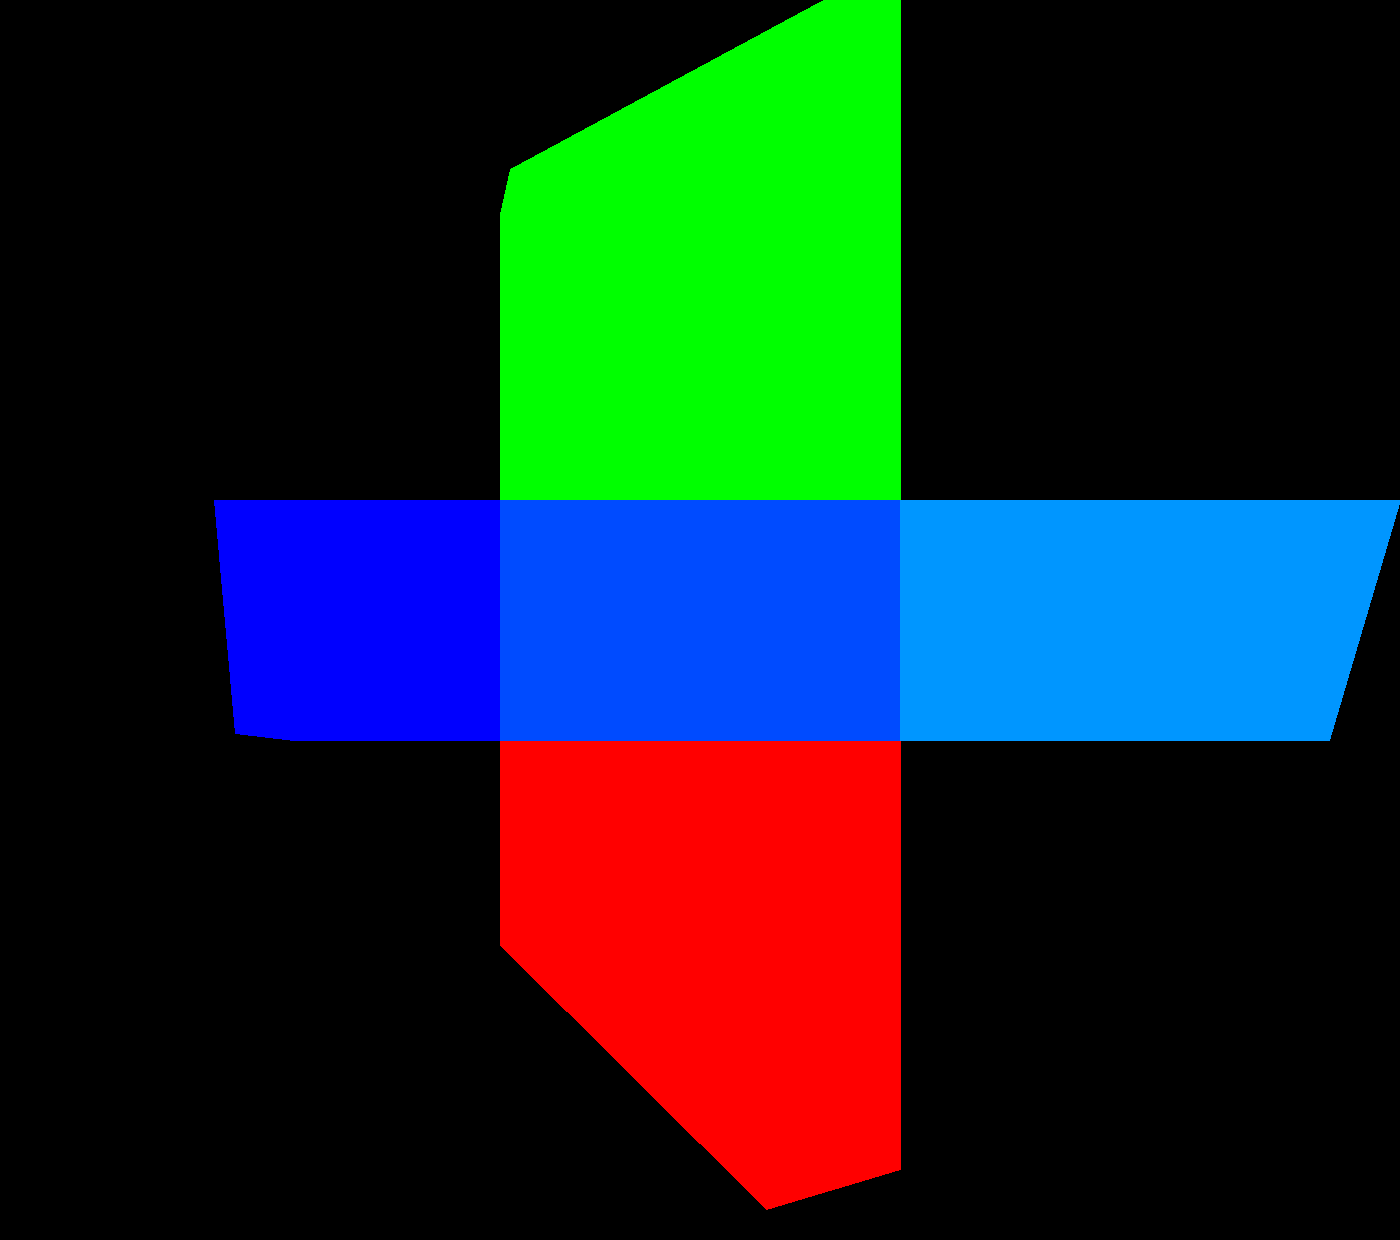

In [ ]:
# Тестирование функции создания маски
ceiling_points = [[0,50],[150,150],[500,120],[800,20]]
floor_points = [[50,600],[170,550],[530,520],[800,550]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, 500, 400, 240)

ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (800, 600))

skin_ceiling_points, skin_floor_points, skin_walls_points = calc_room_skin_points(ceiling_skin_size, floor_skin_size, walls_skin_size, 500, 400, 240)

room_skin = create_room_skin(skin_ceiling_points, skin_floor_points, skin_walls_points, (1240, 1400))

cv2_imshow(room_skin)

re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points = room_skin_corrector(ceiling_points, floor_points, wall_points, ceiling_mask, floor_mask, wall_masks, skin_ceiling_points, skin_floor_points, skin_walls_points)

room_re_skin = create_room_skin(re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points, (1240, 1400))

cv2_imshow(room_re_skin)

# Поворот, масштабирование и сдвиг координат

In [ ]:
# Функция поворота и масштабирования координат
def coors_rotation(coords, center = (500, 300), angle = 90, scale = 1):
  '''
  Функция пороворота и масштабирования координат.
    coords - список координат;
    center - центр вращения;
    angle - угол поворота в градусах;
    scale - коэффициент масштабирования.
  '''

  rot_mat = cv2.getRotationMatrix2D(center, angle, scale )

  transformed_coords = []

  for c in coords:
    transformed_coords.append(np.dot(rot_mat, np.array([c[0],c[1],1])).tolist())

  return transformed_coords

In [ ]:
# Функция сдвига точек
def coors_moving(coords, dx, dy):
  '''
  Функция сдвига координат.
    coords - спискок координат;
    dx - сдвиг по оси х;
    dy - сдвиг по оси y.
  '''

  # Если одноуровневый спискок координат
  if len(coords[0]) == 2 and type(coords[0][0]) == list:
      coords_np = np.array(coords)
      coord_np = coords_np + [dx, dy]
      return coord_np.tolist()
  else:
      new_coords = []
      for coords_part in coords:
        coords_part_np = np.array(coords_part)
        coord_part_np = coords_part_np + [dx, dy]
        new_coords.append(coord_part_np.tolist())
      return new_coords

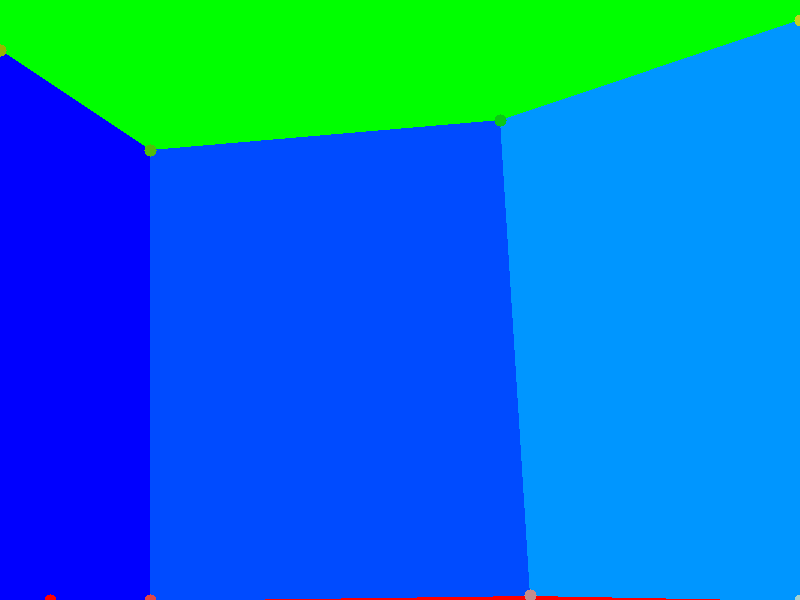

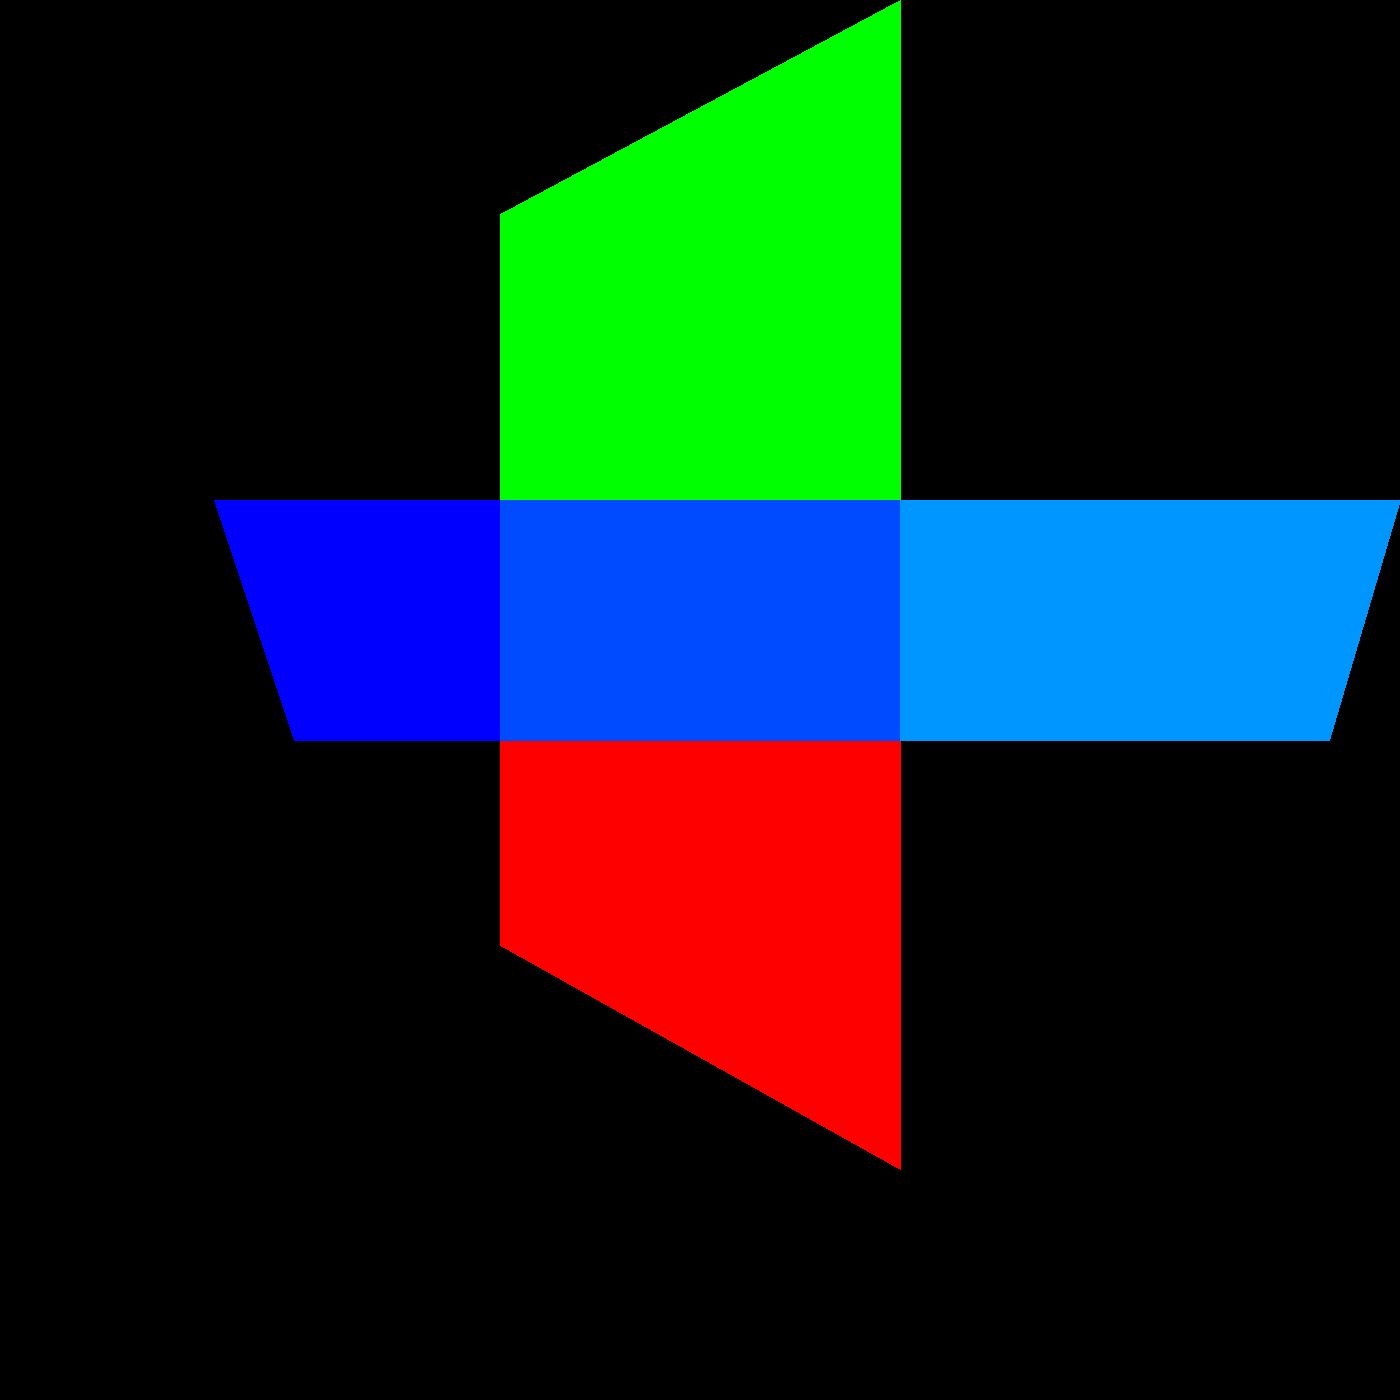

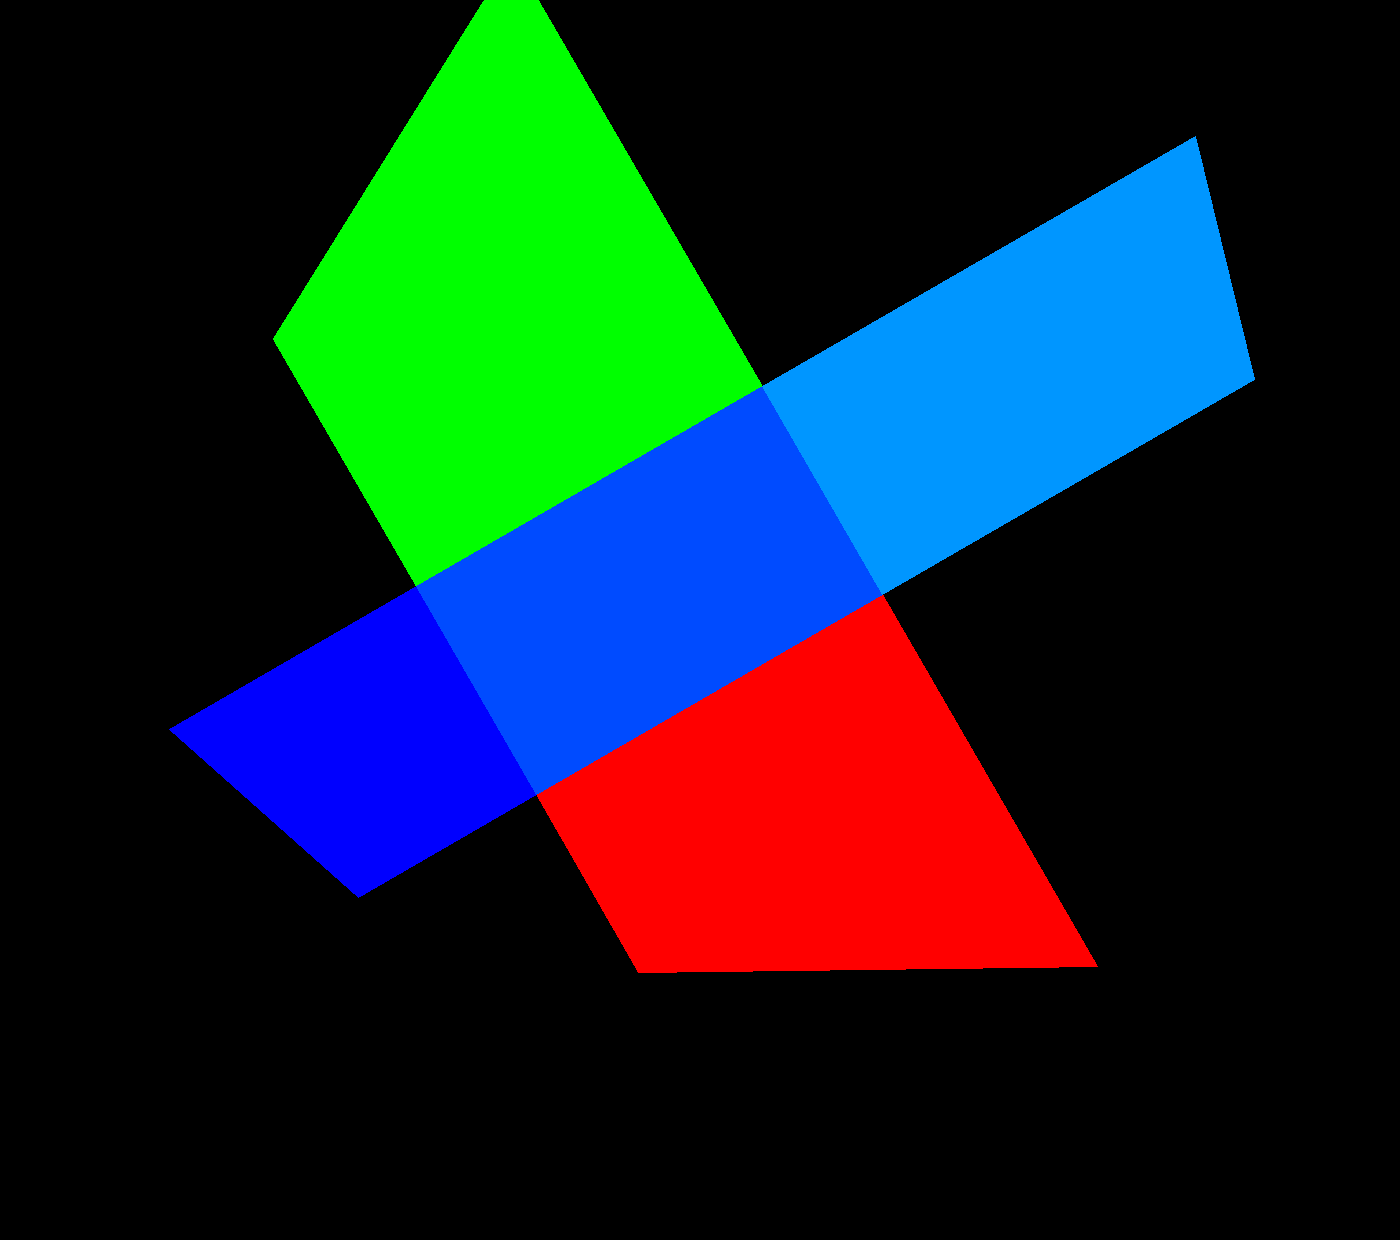

In [ ]:
# Тестирование функции создания маски
ceiling_points = [[0,50],[150,150],[500,120],[800,20]]
floor_points = [[50,600],[150,600],[530,595],[800,600]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, 500, 400, 240)

ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (800, 600))

skin_ceiling_points_r = coors_rotation(skin_ceiling_points, center = (620, 700), angle = 30, scale = 1)

skin_floor_points_r = coors_rotation(skin_floor_points, center = (620, 700), angle = 30, scale = 1)

skin_walls_points_r = []

for w in skin_walls_points:
  skin_walls_points_r.append(coors_rotation(w, center = (620, 700), angle = 30, scale = 1))

room_skin = create_room_skin(skin_ceiling_points, skin_floor_points, skin_walls_points, (1400, 1400))

room_skin_r = create_room_skin(skin_ceiling_points_r, skin_floor_points_r, skin_walls_points_r, (1240, 1400))

cv2_imshow(room_skin)

cv2_imshow(room_skin_r)

# Вычисление необходимого размера текстуры

In [ ]:
# Определение максимального и минимального значения координат
def calc_xy_limits(coords):

    '''
    Функция для вычисления максимальных и минимальных значения по осям X и Y
    '''
    all_xy = []

    for level_1 in coords:
        for level_2 in level_1:
            if type(level_2) == list:
                for level_3 in level_2:
                    all_xy.append(level_3)
            else:
                all_xy.append(level_2)
    all_x = all_xy[::2]
    all_y = all_xy[1::2]
    return [min(all_x),min(all_y),max(all_x),max(all_y)]

In [ ]:
# Вычисление требуемого размера текстуры
def draw_sceleton(points, json_path, angle, custom_shift = None, herringbone = 2, rescale = None, thickness=15):

    '''
    Функция для отображения контура развертки на подготовленной текстуре
      points - точки развертки;
      json_path - путь к JSON файлу с параметрами текстуры;
      angle - угол поворота в градусах (вращается развертка, текстура не подвижна)
      custom_shift - смещение в направлении длины отличное от параметров текстуры по умолчанию (%);
      herringbone - укладка ёлочкой:
                        None или 0 - нет укладки ёлочкой;
                        1 и выше - ёлочка с соответствующим количеством планок;
                        Смещение при укладке ёлочкой не работает.
    '''

    x_min, y_min, x_max, y_max = calc_xy_limits(points)
    min_size = ((x_max-x_min)**2+(y_max-y_min)**2)**0.5
    # Создание подходящего полотна
    texture_field = create_texture_canvas(min_size, min_size, json_path, custom_shift, herringbone, rescale)
    texture_size = texture_field.shape[0]
    scale_coef = texture_size/min_size

    new_points = coors_moving(points, -(x_max-x_min)/2-x_min+texture_size/2, -(y_max-y_min)/2-y_min+texture_size//2)

    image = texture_field.copy()

    if len(new_points[0]) == 2:
        scaled_points = coors_rotation(new_points, (texture_size//2, texture_size//2), angle, scale_coef)
        cv2.polylines(image, pts=[np.array(scaled_points).astype(np.int64)], color=(0,0,255), isClosed = True, thickness=thickness)
    else:
        for p in new_points:
            scaled_points = coors_rotation(p, (texture_size//2, texture_size//2), angle, scale_coef)
            cv2.polylines(image, pts=[np.array(scaled_points).astype(np.int64)], color=(0,0,255), isClosed = True, thickness=thickness)

    cv2_imshow(cv2.resize(image,(800,800)))

In [ ]:
# Вычисление требуемого размера текстуры
def prepare_texture(points, json_path, custom_shift = None, herringbone = 2, dx = 0, dy = 0, rescale = None):

    '''
      Функция подготовки текстуры нужных размеров для отображения точек развертки.
      Для обеспечения возможности поворота, вычисляется диагональ.
      Есть возможность задать дополнительный запас по осям для смещения.
      Функция возвращает созданную текстуру, а также коэффициент масштабирования точек развертки и необходимое смещение.
    '''

    x_min, y_min, x_max, y_max = calc_xy_limits(points)
    min_size = ((x_max-x_min)**2+(y_max-y_min)**2)**0.5
    # Создание подходящего полотна
    texture_field = create_texture_canvas(min_size+dx, min_size+dy, json_path, custom_shift, herringbone, rescale)

    # Вычисление коэффициента масштабирования
    texture_size = texture_field.shape[0]
    scale_coef = texture_size/min_size

    # Вычисление смещения центра точек в начало координат
    points_dx = (x_max+x_min)/2
    points_dy = (y_max+y_min)/2

    return texture_field, texture_size, scale_coef, points_dx, points_dy

def build_sceleton_points(points, angle, texture_size, scale_coef, dx, dy):

    '''
    Функция пересчета точек развертки в координаты пикселей на текстуре с учетом подготовленной текстуры
      texture_field - NumPy массив текстуры (используется для пересчета масштаба точек);
      points - точки развертки;
      angle - угол поворота в градусах (вращается развертка, текстура не подвижна).
    '''

    new_points = coors_moving(points, texture_size//2-dx, texture_size//2-dy)

    if len(new_points[0]) == 2:
        scaled_points = coors_rotation(new_points, (texture_size//2, texture_size//2), angle, scale_coef)
    else:
        scaled_points = []
        for p in new_points:
            scaled_points.append(coors_rotation(p, (texture_size//2, texture_size//2), angle, scale_coef))
    return scaled_points

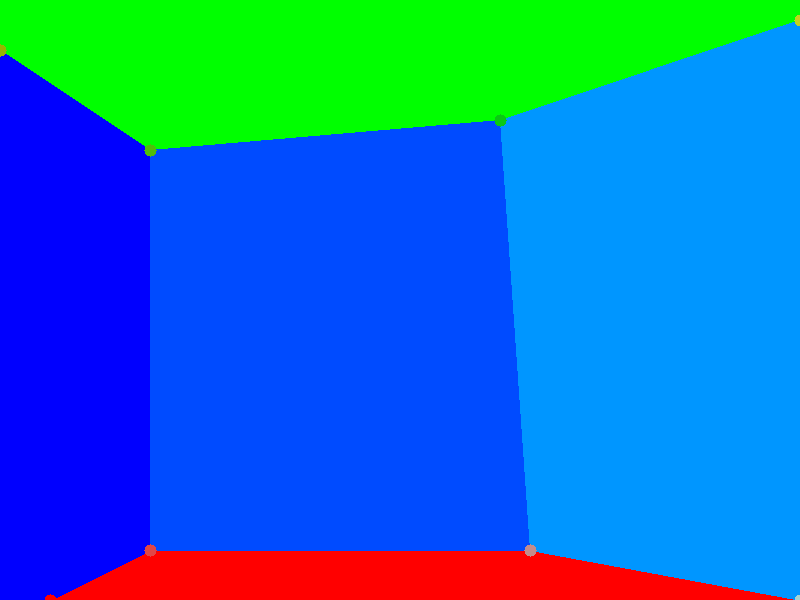

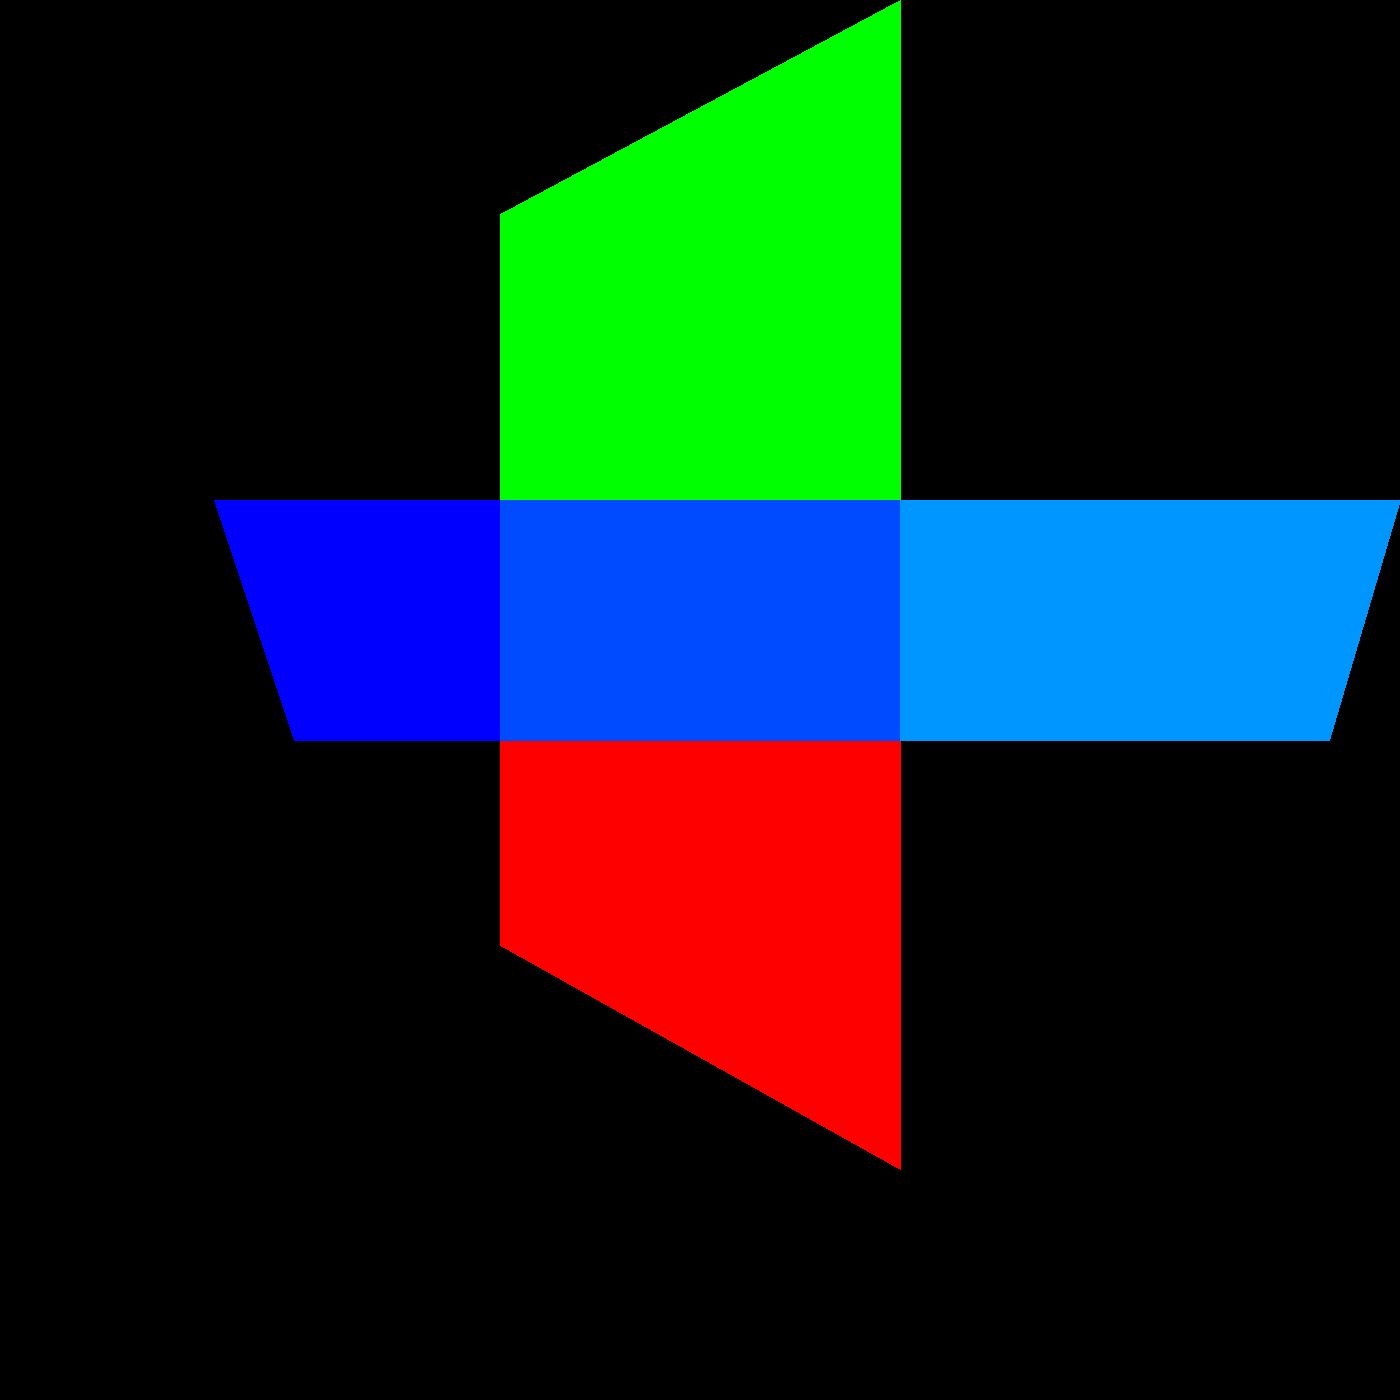

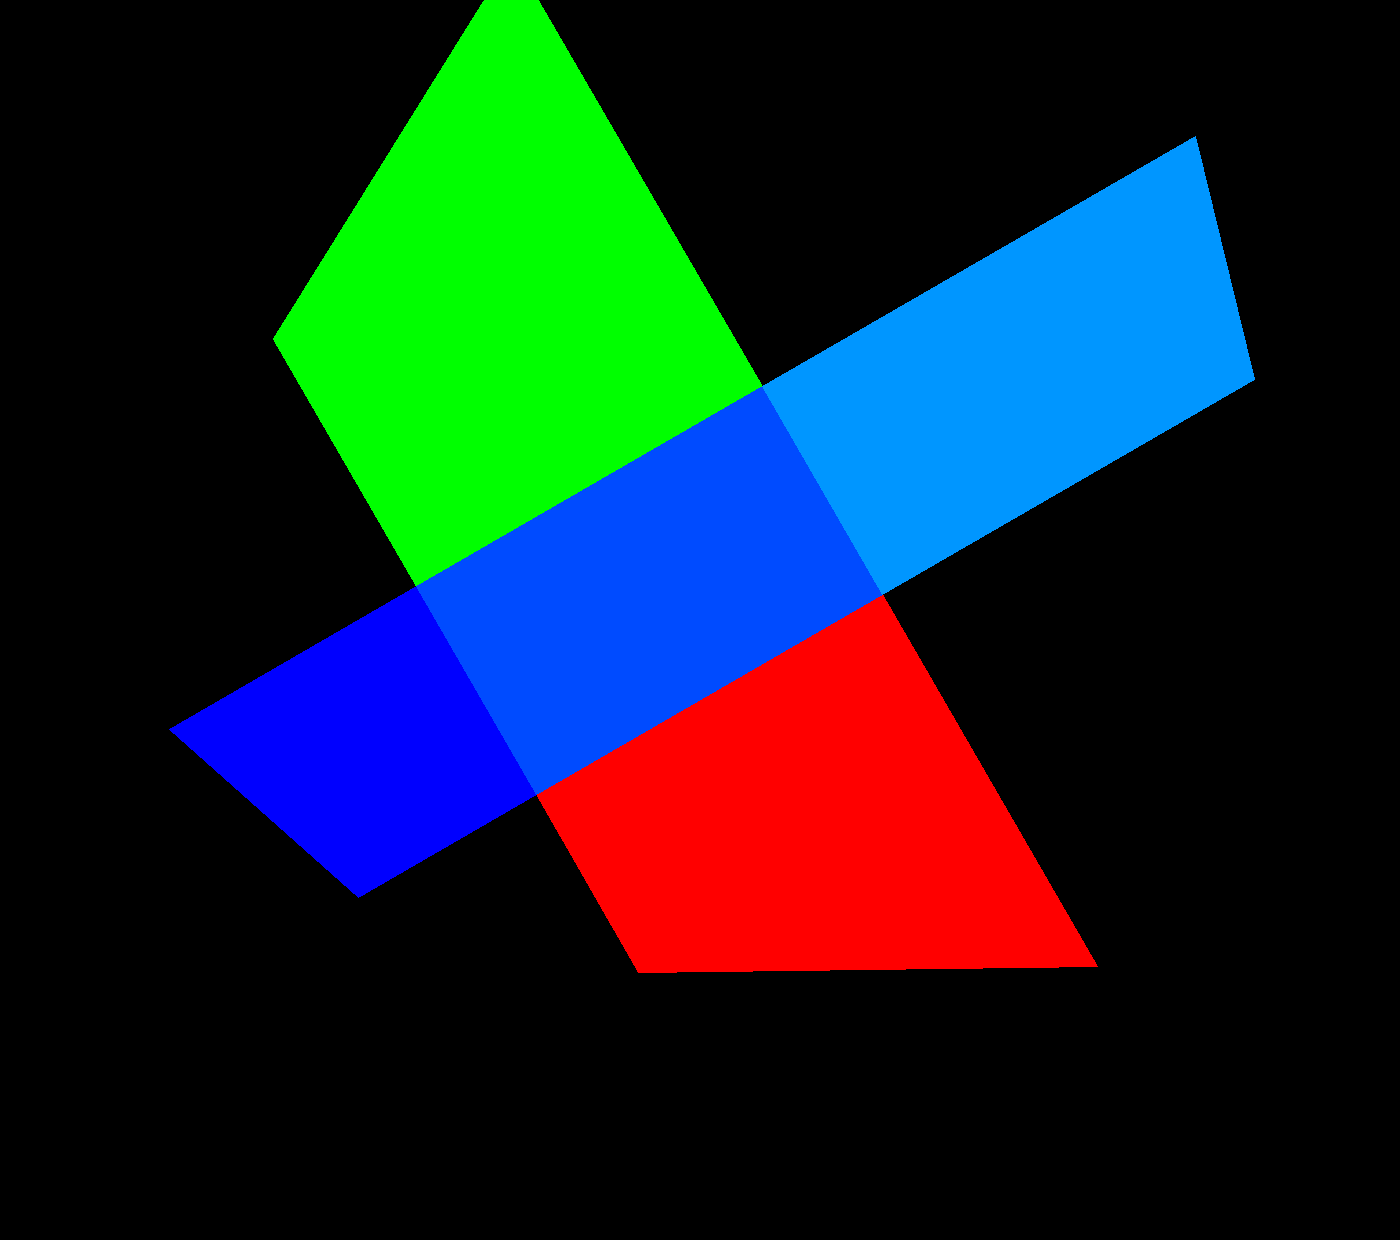

In [ ]:
# Тестирование функции создания маски и её поворот
ceiling_points = [[0,50],[150,150],[500,120],[800,20]]
floor_points = [[50,600],[150,550],[530,550],[800,600]]

mask = build_mask(ceiling_points, floor_points)

cv2_imshow(mask)

ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, 500, 400, 240)

ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (800, 600))

skin_ceiling_points_r = coors_rotation(skin_ceiling_points, center = (620, 700), angle = 30, scale = 1)

skin_floor_points_r = coors_rotation(skin_floor_points, center = (620, 700), angle = 30, scale = 1)

skin_walls_points_r = []

for w in skin_walls_points:
  skin_walls_points_r.append(coors_rotation(w, center = (620, 700), angle = 30, scale = 1))

room_skin = create_room_skin(skin_ceiling_points, skin_floor_points, skin_walls_points, (1400, 1400))


room_skin_r = create_room_skin(skin_ceiling_points_r, skin_floor_points_r, skin_walls_points_r, (1240, 1400))

cv2_imshow(room_skin)

cv2_imshow(room_skin_r)

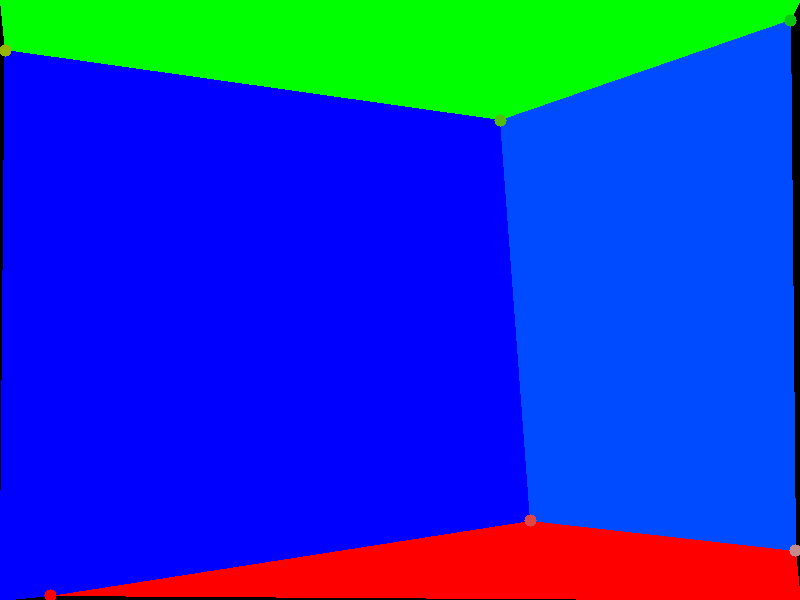

In [ ]:
# Тестирование функции создания маски и наложения ее на текстуру
# ceiling_points = [[50,0],[150,150],[500,120],[800,20]]
# floor_points = [[50,600],[150,550],[530,450],[800,500]]

# Тестирование функции создания маски и ее развертки
ceiling_points = [[5,50],[500,120],[790,20]]
floor_points = [[50,595],[530,520],[795,550]]

mask = build_mask(ceiling_points, floor_points)
walls_points = calc_walls(ceiling_points, floor_points)

cv2_imshow(mask)

ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, 500, 400, 240)

ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (800, 600))

skin_ceiling_points, skin_floor_points, skin_walls_points = calc_room_skin_points(ceiling_skin_size, floor_skin_size, walls_skin_size, 500, 400, 240)

re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points = room_skin_corrector(ceiling_points, floor_points, wall_points, ceiling_mask, floor_mask, wall_masks, skin_ceiling_points, skin_floor_points, skin_walls_points)

(1380, 920, 3)


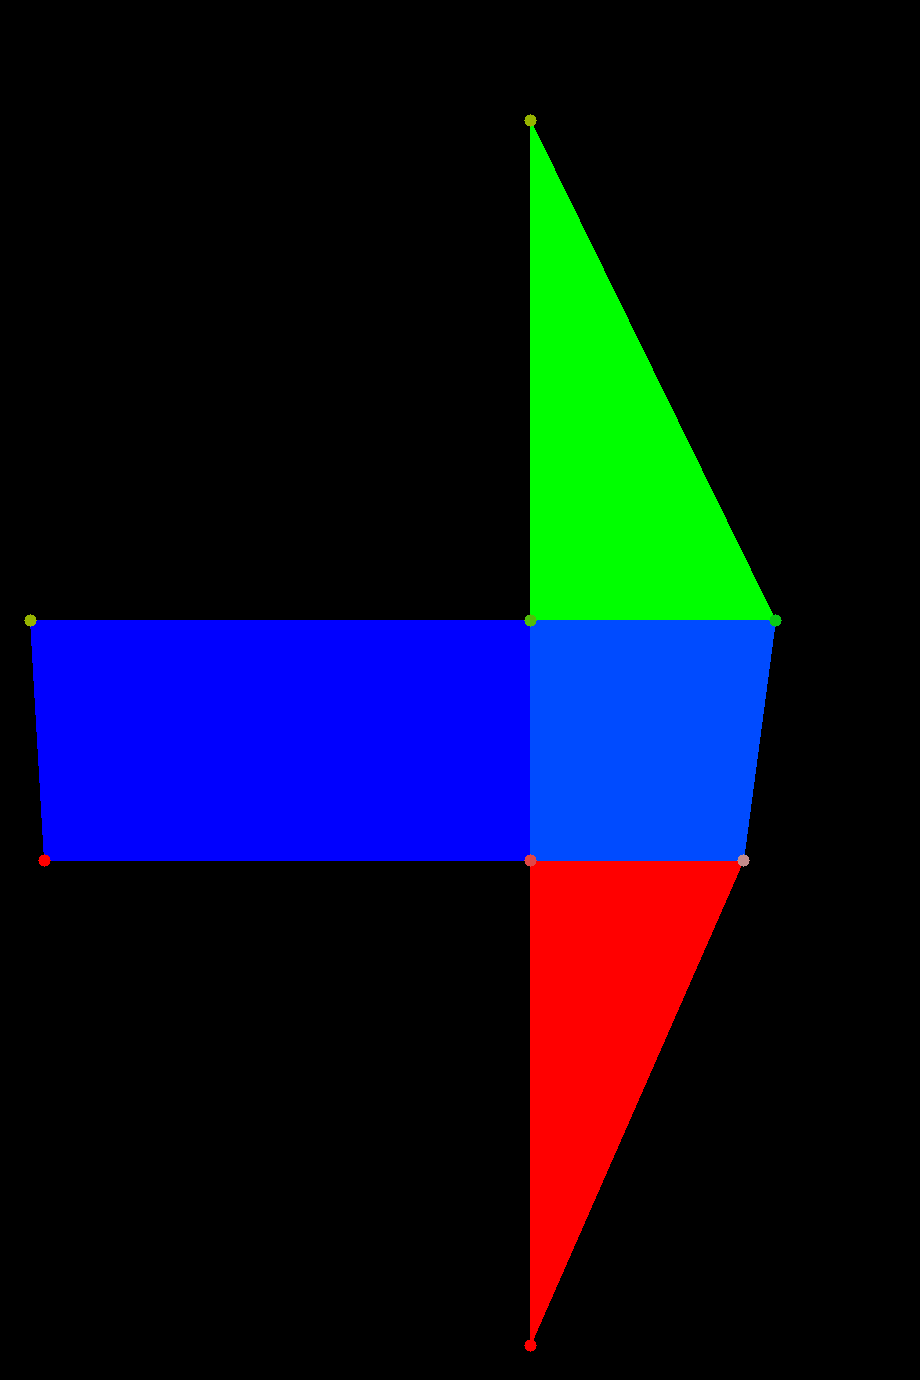

(1380, 920, 3)


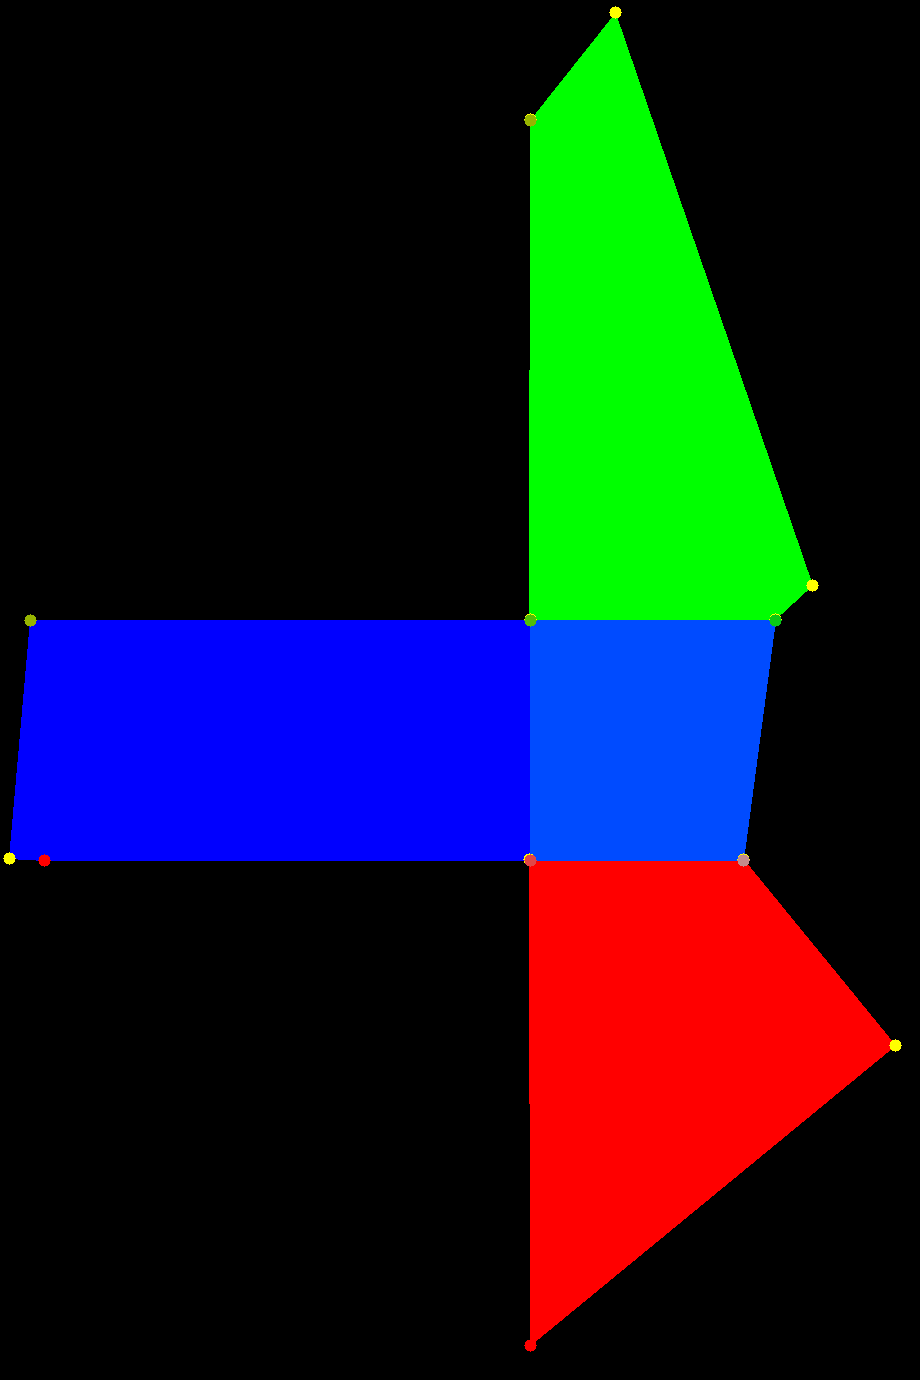

In [ ]:
# Построение разверток с точками
dx = 30
dy = 120
size = (890, 1260)

room_skin = create_room_skin(skin_ceiling_points, skin_floor_points, skin_walls_points, size, dx, dy)

room_skin = draw_points(room_skin, coors_moving(skin_ceiling_points, dx, dy), (0,180,150), (10,10,-70), 6)
room_skin = draw_points(room_skin, coors_moving(skin_floor_points, dx, dy), (0,0,255), (70,70,-30), 6)

room_skin = draw_points(room_skin, coors_moving([skin_walls_points[0][0]], dx, dy), (0,180,150), (10,10,-70), 6)
room_skin = draw_points(room_skin, coors_moving([skin_walls_points[0][1]], dx, dy), (0,0,255), (70,70,-30), 6)

cv2_imshow(room_skin)

re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points = room_skin_corrector(ceiling_points, floor_points, wall_points, ceiling_mask, floor_mask, wall_masks, skin_ceiling_points, skin_floor_points, skin_walls_points)

room_re_skin = create_room_skin(re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points, size, dx, dy)

room_re_skin = draw_points(room_re_skin, coors_moving(re_skin_ceiling_points, dx, dy), (0,255,255), (0,0,0), 6)
room_re_skin = draw_points(room_re_skin, coors_moving(re_skin_floor_points, dx, dy), (0,255,255), (0,0,0), 6)
for re_wall_points in re_skin_walls_points:
  room_re_skin = draw_points(room_re_skin, coors_moving(re_wall_points, dx, dy), (0,255,255), (0,0,0), 6)

room_re_skin = draw_points(room_re_skin, coors_moving(skin_ceiling_points, dx, dy), (0,180,150), (10,10,-70), 6)
room_re_skin = draw_points(room_re_skin, coors_moving(skin_floor_points, dx, dy), (0,0,255), (70,70,-30), 6)

room_re_skin = draw_points(room_re_skin, coors_moving([skin_walls_points[0][0]], dx, dy), (0,180,150), (10,10,-70), 6)
room_re_skin = draw_points(room_re_skin, coors_moving([skin_walls_points[0][1]], dx, dy), (0,0,255), (70,70,-30), 6)

cv2_imshow(room_re_skin)

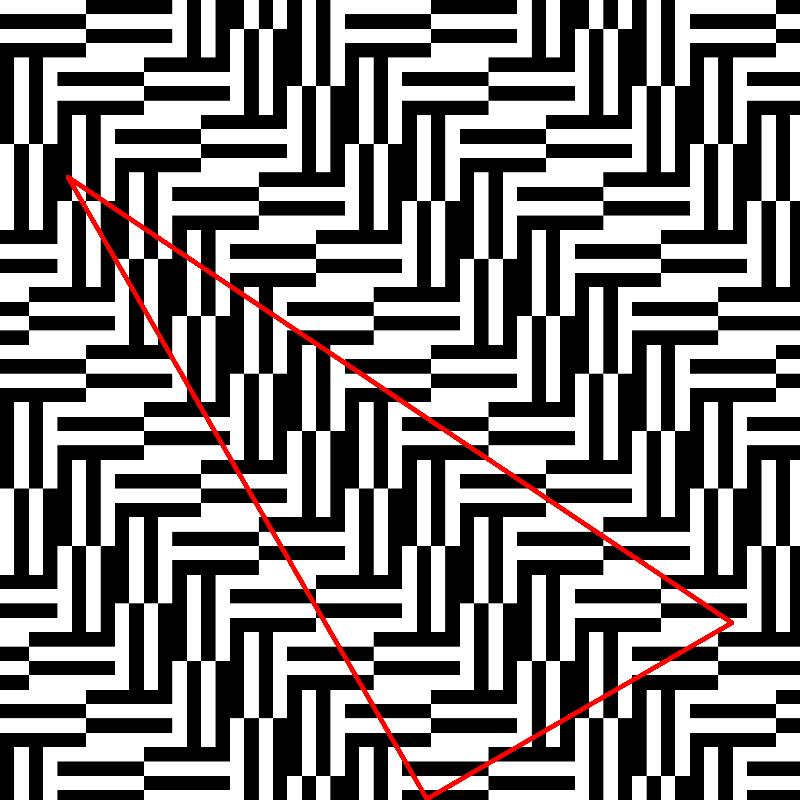

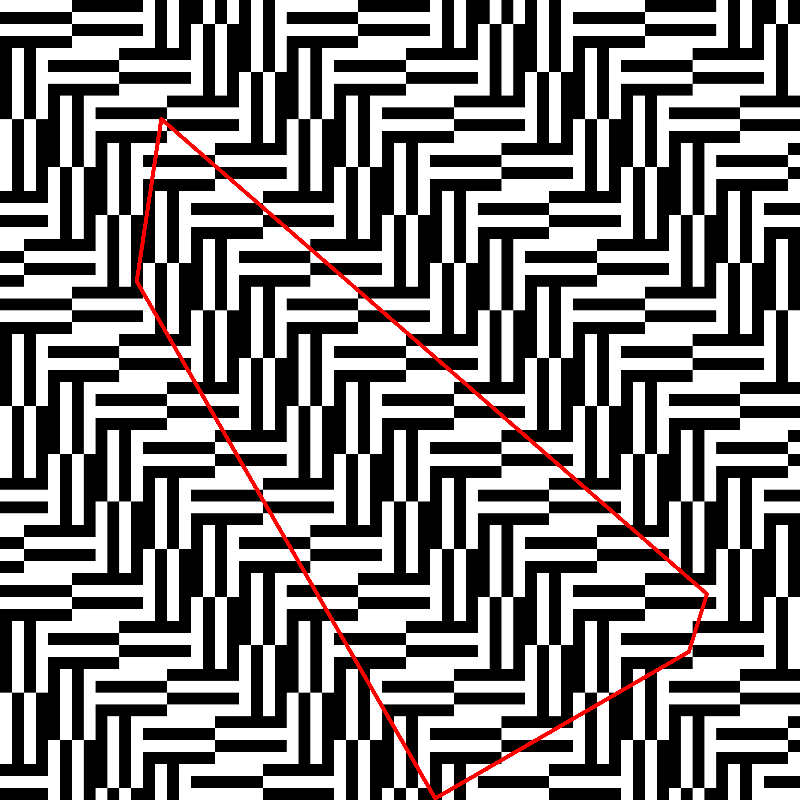

In [ ]:
# Сравнение контура потолка без и с угловыми точками
draw_sceleton(skin_ceiling_points, '/content/Test_Texture.json', 30)
draw_sceleton(re_skin_ceiling_points, '/content/Test_Texture.json', 30)

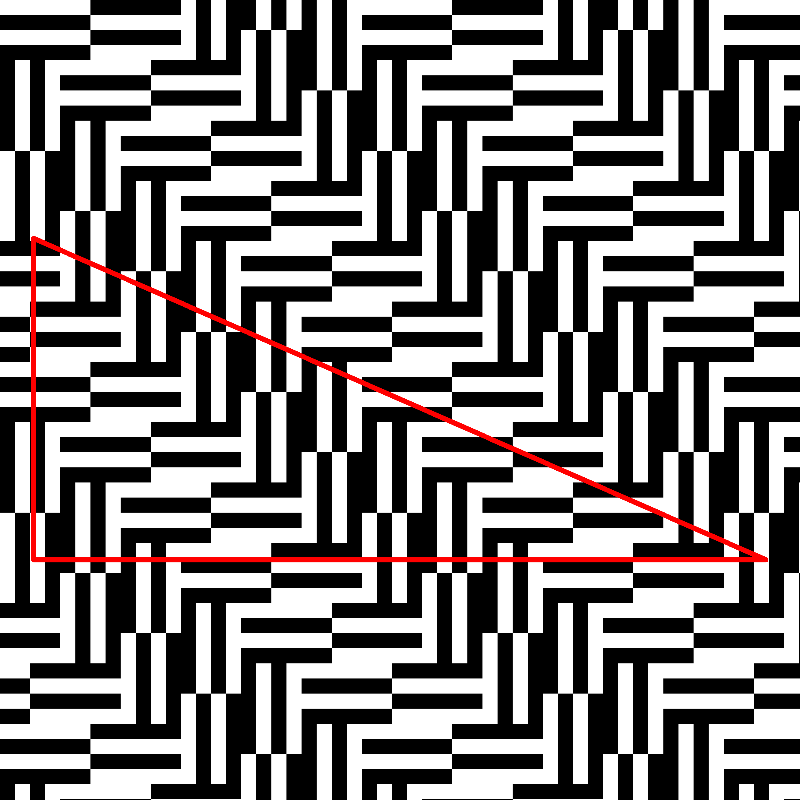

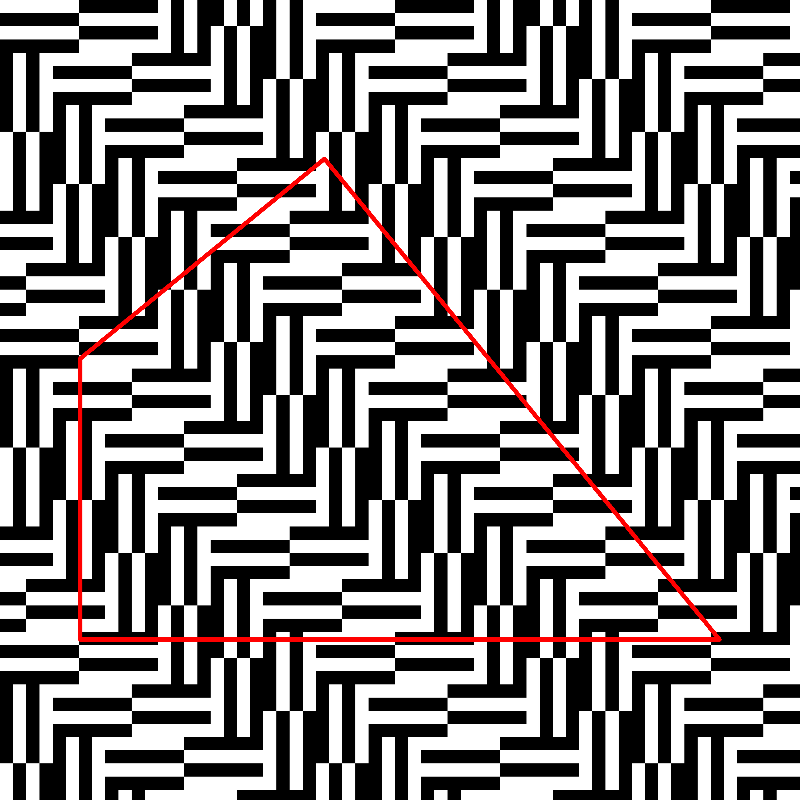

In [ ]:
# Сравнение контура пола без и с угловыми точками
draw_sceleton(skin_floor_points, '/content/Test_Texture.json', 90)
draw_sceleton(re_skin_floor_points, '/content/Test_Texture.json', 90)

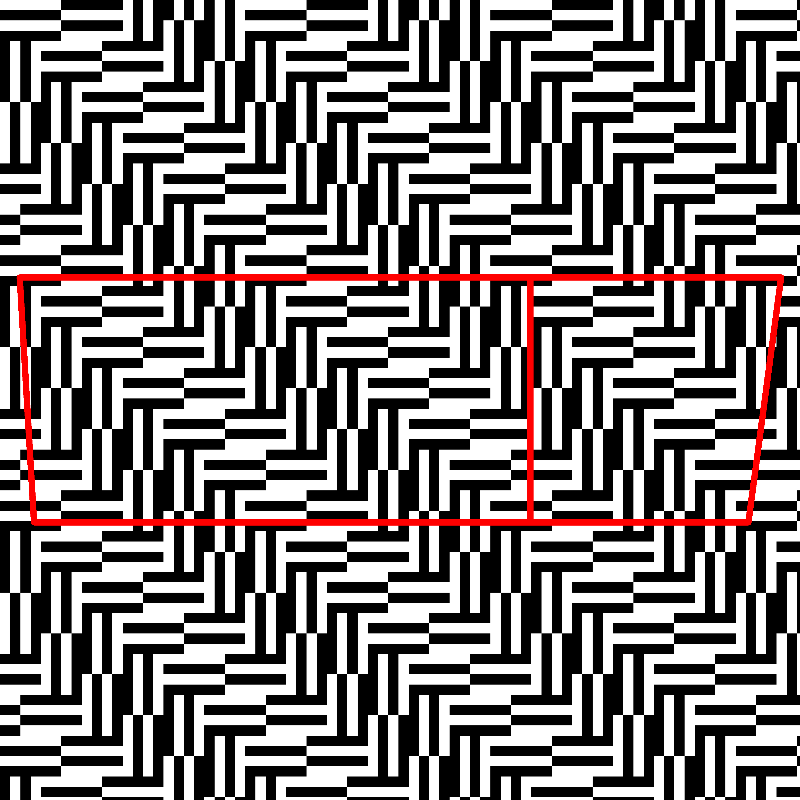

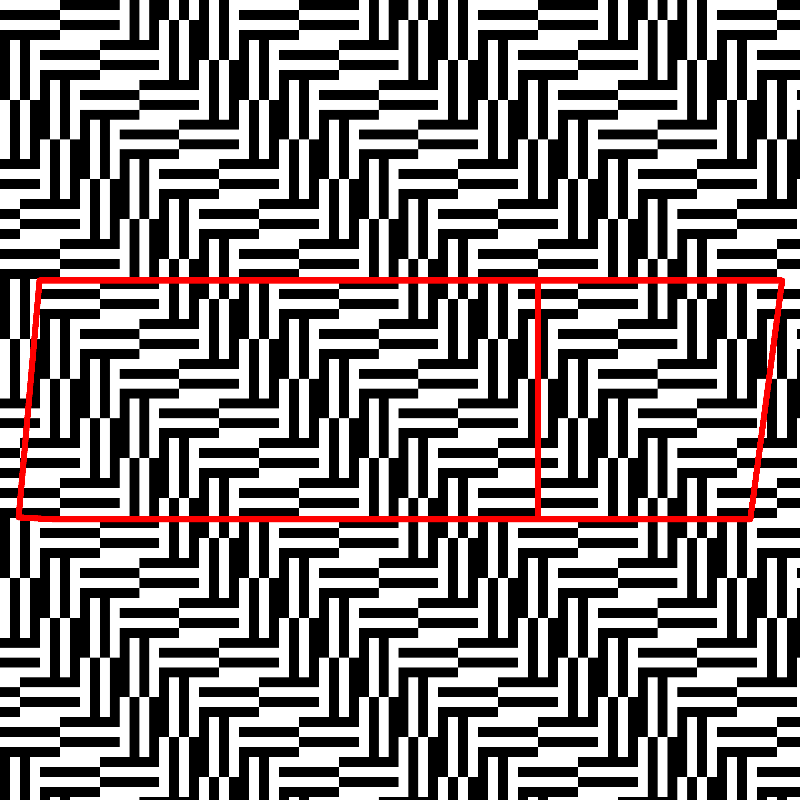

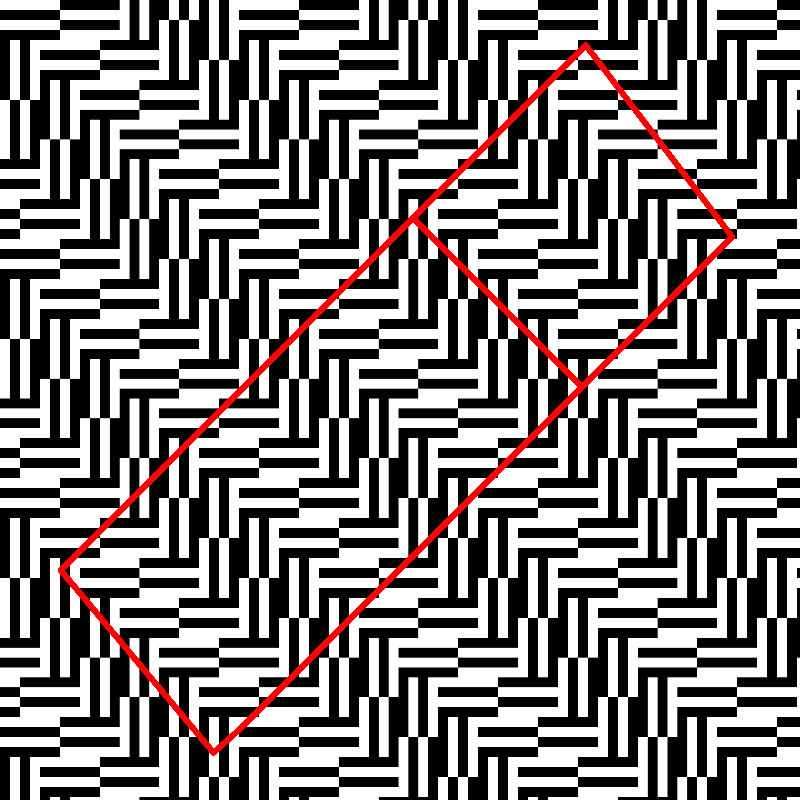

In [ ]:
# Сравнение контура стен без и с угловыми точками
draw_sceleton(skin_walls_points, '/content/Test_Texture.json', 0, thickness=30)
draw_sceleton(re_skin_walls_points, '/content/Test_Texture.json', 0, thickness=30)
draw_sceleton(re_skin_walls_points, '/content/Test_Texture.json', 45, thickness=30)

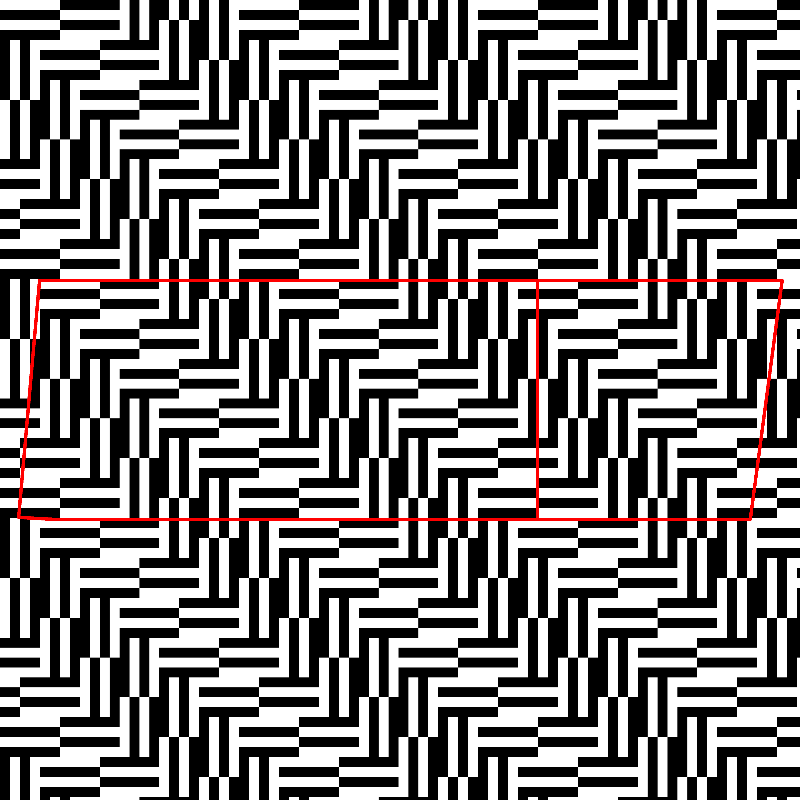

In [ ]:
draw_sceleton(re_skin_walls_points, '/content/Test_Texture.json', 0)

In [ ]:
# Подготовка текстуры стен без дополнительных точек
points = skin_walls_points
angle = 45
texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(points, '/content/Test_Texture.json')
scaled_points = build_sceleton_points(points, angle, texture_size, scale_coef, points_dx, points_dy)

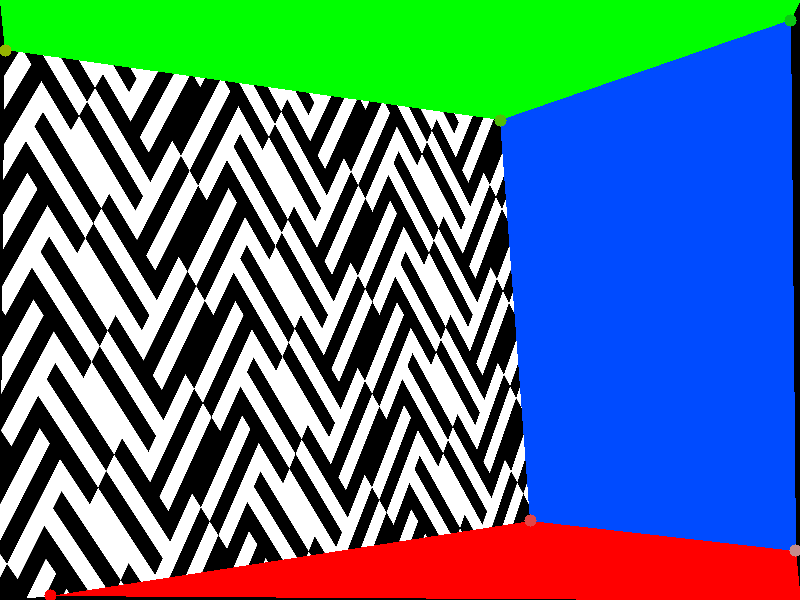

In [ ]:
transformed_texture = texture_transformation(texture_field, scaled_points[0], walls_points[0], destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(mask, transformed_texture, mask, (255,0,0))
cv2_imshow(textured_mask)

In [ ]:
# Подготовка текстуры стен с учетом дополнительных точек
points = skin_walls_points
angle = 45
texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(re_skin_walls_points, '/content/Test_Texture.json')
scaled_points = build_sceleton_points(points, angle, texture_size, scale_coef, points_dx, points_dy)

In [ ]:
# # Отображение точек потолка
# for i in range(len(ceiling_points)):
#     cv2.circle(transformed_texture,ceiling_points[i],5,(0,255,255),-1)

# # Отображение точек пола
# for i in range(len(floor_points)):
#     cv2.circle(transformed_texture,floor_points[i],5,(0,255,255),-1)

# cv2_imshow(transformed_texture)

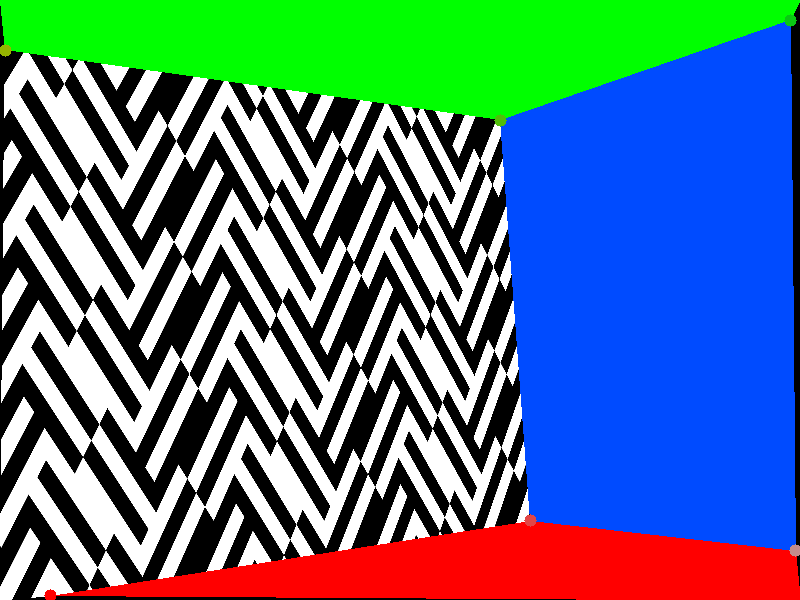

In [ ]:
transformed_texture = texture_transformation(texture_field, scaled_points[0], walls_points[0], destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(mask, transformed_texture, mask, (255,0,0))
cv2_imshow(textured_mask)

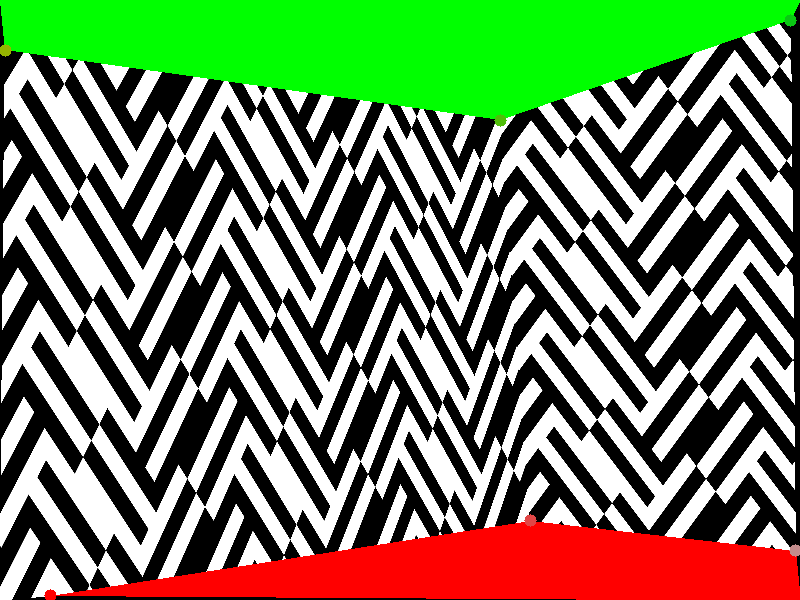

In [ ]:
transformed_texture = texture_transformation(texture_field, scaled_points[1][:3], walls_points[1][:3], destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (255,75,0))
cv2_imshow(textured_mask)

In [ ]:
transformed_texture = texture_transformation(texture_field, scaled_points[2], walls_points[2], destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (255,150,0))
cv2_imshow(textured_mask)

IndexError: list index out of range

# Тест на реальной текстуре

In [ ]:
ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, 500, 400, 240)


ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (800, 600))

skin_ceiling_points, skin_floor_points, skin_walls_points = calc_room_skin_points(ceiling_skin_size, floor_skin_size, walls_skin_size, 500, 400, 240)

re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points = room_skin_corrector(ceiling_points, floor_points, wall_points, ceiling_mask, floor_mask, wall_masks, skin_ceiling_points, skin_floor_points, skin_walls_points)

In [ ]:
# Тестирование функции создания маски
json_path_wall = '/content/drive/MyDrive/PROBKI/TexturesPack/desire.json'
json_path_floor = '/content/drive/MyDrive/PROBKI/TexturesPack/Oak Virginia White.json'
json_path_ceiling= '/content/drive/MyDrive/PROBKI/TexturesPack/random.json'

room_l = 900
room_w = 600
room_h = 240

# ceiling_points = [[0,50],[350,150],[800,20]]
# floor_points = [[50,600],[370,450],[800,600]]

# ceiling_points = [[0,50],[150,150],[500,120],[800,20]]
# floor_points = [[50,600],[150,450],[530,450],[800,600]]

# ceiling_points = [[150,0],[350,150],[500,120],[800,20]]
# floor_points = [[150,600],[330,450],[530,450],[800,500]]

# mask = build_mask(ceiling_points, floor_points)
# walls_points = calc_walls(ceiling_points, floor_points)

ceiling_points = [[300,0],[700,300],[1000,240],[1600,40]]
floor_points = [[300,1200],[660,900],[1060,900],[1600,1000]]

mask = build_mask(ceiling_points, floor_points, (1600,1200))
walls_points = calc_walls(ceiling_points, floor_points)

cv2_imshow(mask)

ceiling_skin_size, floor_skin_size, walls_skin_size, wall_points = calc_room_skin_sizes(ceiling_points, floor_points, room_l, room_w, room_h)

ceiling_mask, floor_mask, wall_masks = add_mask_points(ceiling_points, floor_points, wall_points, size = (mask.shape[1], mask.shape[0]))

skin_ceiling_points, skin_floor_points, skin_walls_points = calc_room_skin_points(ceiling_skin_size, floor_skin_size, walls_skin_size, room_l, room_w, room_h)

re_skin_ceiling_points, re_skin_floor_points, re_skin_walls_points = room_skin_corrector(ceiling_points, floor_points, wall_points, ceiling_mask, floor_mask, wall_masks, skin_ceiling_points, skin_floor_points, skin_walls_points)

In [ ]:
angle_w = 30
angle_f = 90
angle_c = 45

rescale = 1.5

draw_sceleton(skin_walls_points, json_path_wall, angle_w, rescale = rescale)
draw_sceleton(skin_floor_points, json_path_floor, angle_f, rescale = rescale)
draw_sceleton(skin_ceiling_points, json_path_ceiling, angle_c, rescale = rescale)

In [ ]:
# Алгоритм без корректировочных точек

textured_mask = mask.copy()

texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(skin_walls_points, json_path_wall, rescale = rescale)
print(texture_field.shape)
scaled_points = build_sceleton_points(skin_walls_points, angle_w, texture_size, scale_coef, points_dx, points_dy)

for i in range(len(wall_points)):
    transformed_texture = texture_transformation(texture_field, scaled_points[i], walls_points[i], destination_size = mask.shape[::-1][1:])
    textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (np.array((255,0,0)) + np.array((0,75,0))*i)%256)

texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(skin_floor_points, json_path_floor, rescale = rescale)
print(texture_field.shape)
scaled_points = build_sceleton_points(skin_floor_points, angle_f, texture_size, scale_coef, points_dx, points_dy)

transformed_texture = texture_transformation(texture_field, scaled_points, floor_points, destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (0,0,255))

texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(skin_ceiling_points, json_path_ceiling, rescale = rescale)
print(texture_field.shape)
scaled_points = build_sceleton_points(skin_ceiling_points, angle_c, texture_size, scale_coef, points_dx, points_dy)

transformed_texture = texture_transformation(texture_field, scaled_points, ceiling_points, destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (0,255,0))

cv2_imshow(textured_mask)

In [ ]:
# Алгоритм c учетом корректировочных точек (просто текстуру нужно строить на точках расширенной развертки)

textured_mask = mask.copy()

texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(re_skin_walls_points, json_path_wall, rescale = rescale)
scaled_points = build_sceleton_points(skin_walls_points, angle_w, texture_size, scale_coef, points_dx, points_dy)

for i in range(len(wall_points)):
    transformed_texture = texture_transformation(texture_field, scaled_points[i], walls_points[i], destination_size = mask.shape[::-1][1:])
    textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (np.array((255,0,0)) + np.array((0,75,0))*i)%256)

texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(re_skin_floor_points, json_path_floor, rescale = rescale)
scaled_points = build_sceleton_points(skin_floor_points, angle_f, texture_size, scale_coef, points_dx, points_dy)

transformed_texture = texture_transformation(texture_field, scaled_points, floor_points, destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (0,0,255))

texture_field, texture_size, scale_coef, points_dx, points_dy = prepare_texture(re_skin_ceiling_points, json_path_ceiling, rescale = rescale)
scaled_points = build_sceleton_points(skin_ceiling_points, angle_c, texture_size, scale_coef, points_dx, points_dy)

transformed_texture = texture_transformation(texture_field, scaled_points, ceiling_points, destination_size = mask.shape[::-1][1:])
textured_mask = texturing_by_mask_color(textured_mask, transformed_texture, mask, (0,255,0))

cv2_imshow(textured_mask)